# 世界幸福报告——聚类分析
![幸福图片](dataset/happiness.jpg)

## 课题目标

本次实验旨在利用给定的数据集进行国家幸福感聚类分析。数据集涵盖了多个影响国家幸福感的指标，包括但不限于：

1. gdp_per_capita - 人均国内生产总值
2. family - 家庭满意度
3. health - 平均健康状况
4. reedom - 自由感受程度
5. generosity - 公众对本国慷慨程度的看法
6. government_trust - 公众对政府的信任程度
7. dystopia_residual - 与世界上最悲观国家的比较得分
8. continent - 国家所在的洲
9. cpi_score - 腐败感知指数，用于排名国家的“公共部门腐败感知水平”
10. Year - 数据属性的年份度量
11. Country - 国家名称
12. social_support - 衡量一个人感受到的社会支持和关爱


通过这次实验，旨在：
- 确定哪些指标对于划分聚类群组具有重要影响，并发现潜在的群组模式或共性特征。
- 使用适当的数据预处理方法，构建并比较不同聚类算法（如K均值、层次聚类等）的效果，选择合适的聚类数目和模型评估指标。
- 最终呈现聚类结果，提供对不同聚类群组的解释和分析，探讨各群组之间的差异性和相似性，并对聚类结果进行合理解释。

## 课题数据集
本次聚类分析所使用的数据集为来自Kaggle竞赛的"Happiness and Corruption 2015-2020"(https://www.kaggle.com/datasets/eliasturk/world-happiness-based-on-cpi-20152020/data), 该数据集对2015-2020《世界幸福报告》（幸福分数是由盖洛普世界民意调查（GWP）中的受访者对主要生活评估问题的平均回答得出的。Cantril Ladder（Cantril阶梯）是其中的核心部分，受访者被要求想象他们能够过上的最好生活，并根据这一标准对他们现有生活的幸福感进行评分）中所有国家的有效数据进行了预处理和汇总，并添加了从transparency(https://www.transparency.org/) 中获得的腐败感知指数，合并了基于国家和年份的数据集，将数据转换为长数据格式，并使用0填充填充了缺失得到数据。数据集共包括132个国家2015-2020年的共792条数据，数据集的目标为利用特征对国家进行聚类，发现潜在的相似性模式和群组，探索在这些年份中国家之间的共性和差异性，并理解不同群组之间的特征差异，为理解影响幸福感的主要因素提供更深入的洞察。

## 数据准备

In [2]:
import pandas as pd 
import numpy as np  #For mathematical calculatons
import seaborn as sns #For data visualization
import matplotlib.pyplot as plt # For plotting graphs
import plotly.graph_objs as go
import warnings      #To ignore warnings
import time
warnings.filterwarnings ("ignore")


from sklearn import cluster,mixture


# import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()

1. 从指定路径加载数据，并对数据进行一定的预处理：按照年份将数据集分割，并移除了指定的列，返回了一个字典，其中包含了每个年份对应的数据集。

In [3]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

class DataPreprocessing:
    def __init__(self, data_path):
        self.data_path = data_path

    def load_data(self):
        df = pd.read_csv(self.data_path)
        return df

    def preprocess_data(self, df):
        column_names = ["gdp_per_capita", "health", "cpi_score", "freedom", "government_trust", "social_support",
                        "dystopia_residual", "Country", "Year", "continent", "generosity", "family",
                        "happiness_score"]

        df = df.reindex(columns=column_names)

        # Filter data by year
        year_range = list(range(2015, 2021))
        data_by_year = {}
        for year in year_range:
            year_data = df[df['Year'] == year]
            year_data = year_data.drop(["happiness_score", "Country", "continent", "Year"], axis=1)

            # Min-Max scaling
            scale = MinMaxScaler()
            year_data_scaled = scale.fit_transform(year_data)
            year_data_scaled = pd.DataFrame(year_data_scaled, columns=year_data.columns)

            data_by_year[year] = year_data_scaled

        return data_by_year

In [4]:
data_path = "dataset/WorldHappiness_Corruption_2015_2020.csv"
data_processor = DataPreprocessing(data_path)
df = data_processor.load_data()
data_by_year = data_processor.preprocess_data(df)

print(data_by_year[2015].describe())
print(data_by_year[2016].describe())
print(data_by_year[2017].describe())
print(data_by_year[2018].describe())
print(data_by_year[2019].describe())
print(data_by_year[2020].describe())

       gdp_per_capita      health   cpi_score     freedom  government_trust  \
count      132.000000  132.000000  132.000000  132.000000        132.000000   
mean         0.554095    0.601912    0.419034    0.614154          0.263904   
std          0.242992    0.229364    0.254682    0.228766          0.221124   
min          0.000000    0.000000    0.000000    0.000000          0.000000   
25%          0.385835    0.455729    0.234375    0.447903          0.118125   
50%          0.599064    0.649011    0.337500    0.650620          0.189462   
75%          0.741133    0.765232    0.568750    0.784728          0.329913   
max          1.000000    1.000000    1.000000    1.000000          1.000000   

       social_support  dystopia_residual  generosity      family  
count           132.0         132.000000  132.000000  132.000000  
mean              0.0           0.587207    0.294481    0.663763  
std               0.0           0.194527    0.165463    0.228505  
min               0.

2. 计算Spearman秩相关系数，了解数据集中不同变量之间的相关性情况。

Spearman秩相关系数是一种可以衡量变量之间线性关系的测量方法。它由美国统计学家威廉·斯皮尔曼 (WilliamSpearman)于1904年发表。它用以反映两个变量之间的线性关系，其值范围在-1~1之间，其中-1表示完全负相关，0表示无相关，1表示完全正相关。当Spearman秩相关系数值越大，表示两组变量之间的关系越紧密。

In [5]:
numeric_df = (data_by_year[2015]+data_by_year[2016]+data_by_year[2017]+data_by_year[2018]+data_by_year[2019]+data_by_year[2020]).select_dtypes(include=['number'])
spearman_cormatrix = numeric_df.corr(method='spearman')
spearman_cormatrix

,gdp_per_capita,health,cpi_score,freedom,government_trust,social_support,dystopia_residual,generosity,family
gdp_per_capita,1.000000,0.954251,0.890651,0.726412,0.435281,0.883983,0.726156,0.078460,0.880560
health,0.954251,1.000000,0.895076,0.744178,0.456069,0.901374,0.709485,0.135552,0.863623
cpi_score,0.890651,0.895076,1.000000,0.762373,0.521604,0.812834,0.661320,0.113726,0.767037
freedom,0.726412,0.744178,0.762373,1.000000,0.589039,0.711578,0.522982,0.340663,0.726803
government_trust,0.435281,0.456069,0.521604,0.589039,1.000000,0.420614,0.328855,0.429245,0.400594
social_support,0.883983,0.901374,0.812834,0.711578,0.420614,1.000000,0.687722,0.122070,0.824422
dystopia_residual,0.726156,0.709485,0.661320,0.522982,0.328855,0.687722,1.000000,-0.023970,0.620606
generosity,0.078460,0.135552,0.113726,0.340663,0.429245,0.122070,-0.023970,1.000000,0.153496
family,0.880560,0.863623,0.767037,0.726803,0.400594,0.824422,0.620606,0.153496,1.000000


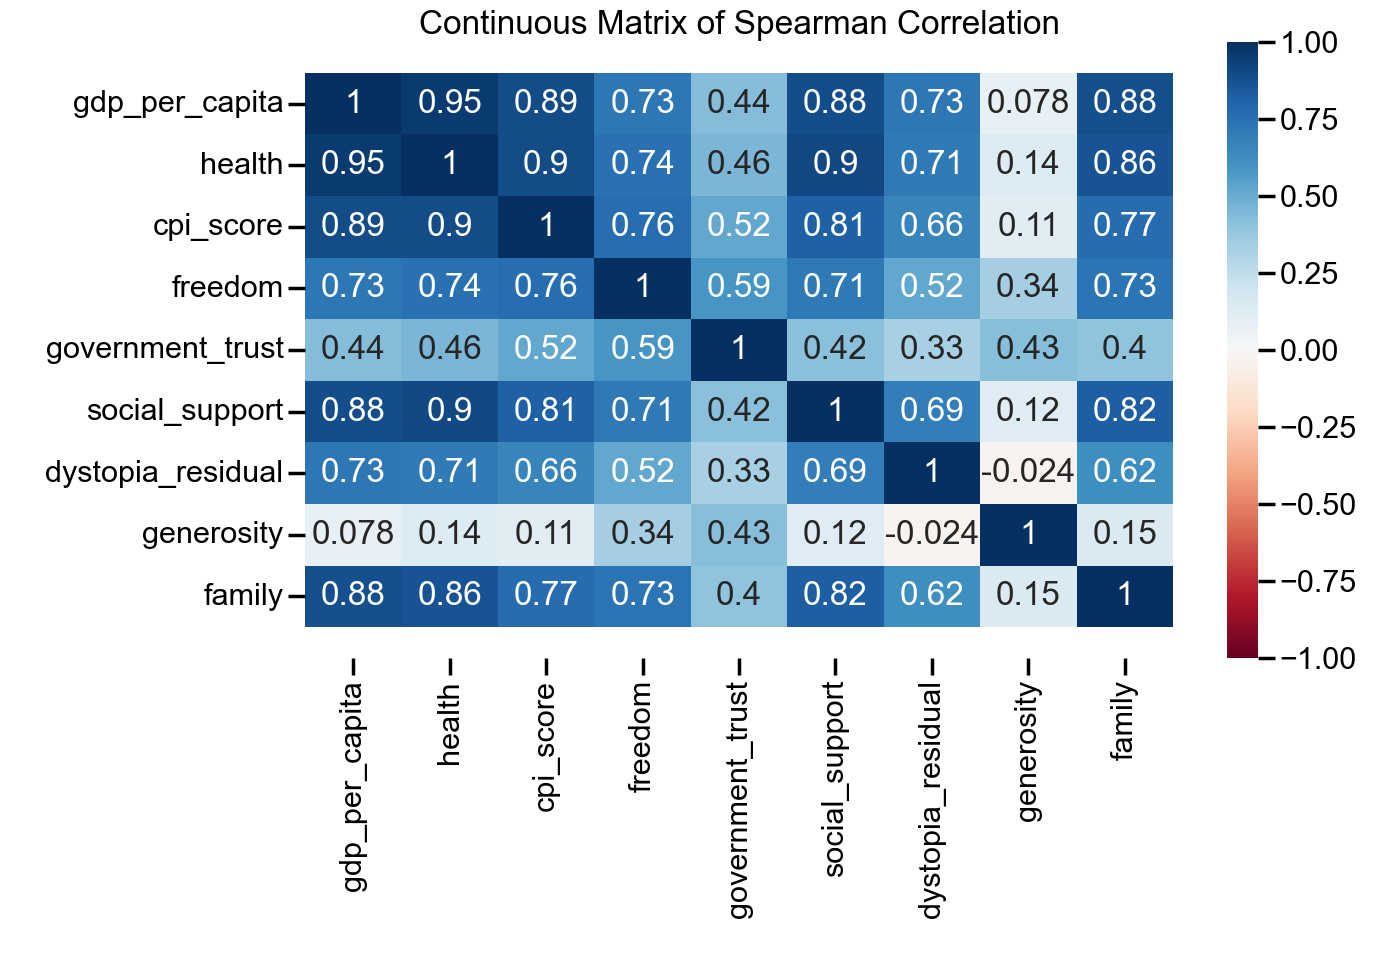

In [6]:
plt.figure(figsize=(14,8))
ax = sns.heatmap(spearman_cormatrix, vmin=-1, vmax=1, center=0, cmap="RdBu", annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);
plt.title("Continuous Matrix of Spearman Correlation");
sns.set(font_scale=1.2)  # 调整Seaborn图上字的大小

可以看出变量展现出不同程度的相关性，这将有助于后续的聚类分析。选择相关性较强的变量作为聚类的特征可能会更有意义，因为这些变量显示出在某种方式下彼此更为密切的关联。这样的选择可以帮助聚类算法更好地捕捉到数据中的模式和结构，从而更有效地组织数据集。从上图中可以看到，选择gdp_per_capita和health之间,gdp_per_capita和cpi_score之间,gdp_per_capita和social_support之间,gdp_per_capita和family之间,health和cpi_score之间,health和social_support之间,health和family之间,cpi_score和social_support之间,cpi_score和family之间有较强的相关性。

3. 利用核密度估计图 (KDE plot)，比较和展示不同年份下各变量的分布情况。每条曲线代表了对应年份某一变量的分布密度，不同颜色的曲线反映了变量在不同年份的表现。通过这组可视化，我们可以观察到各变量在时间上的变化趋势，并比较不同变量之间的波动。这有助于理解这些变量在过去几年中的发展轨迹，为分析这些指标在不同时间段内的变动提供了直观的视角。

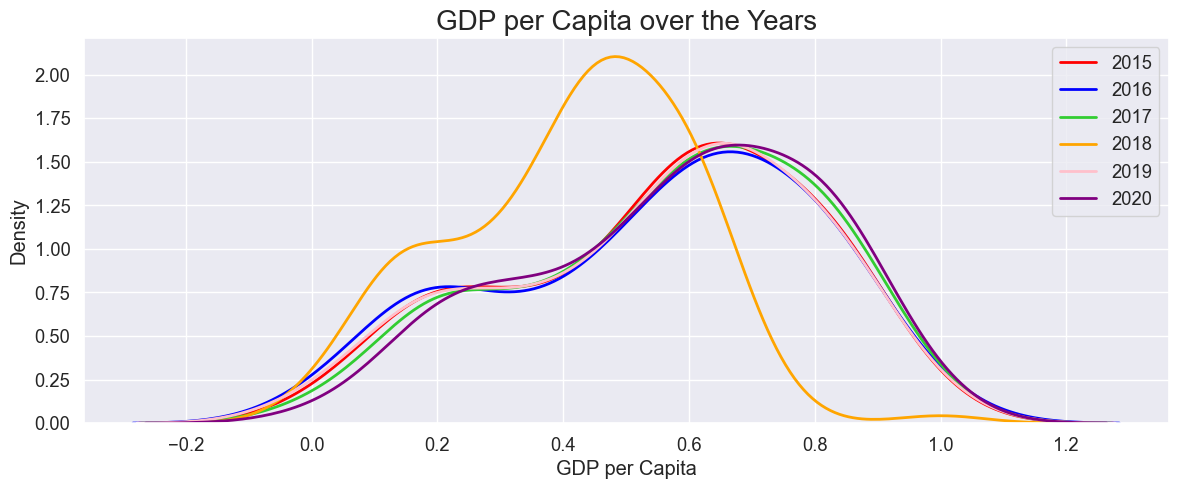

In [7]:
plt.figure(figsize=(14,5))

# 绘制每年的 GDP per Capita 数据
sns.kdeplot(data_by_year[2015]['gdp_per_capita'], color='red', linewidth=2, label='2015')
sns.kdeplot(data_by_year[2016]['gdp_per_capita'], color='blue', linewidth=2, label='2016')
sns.kdeplot(data_by_year[2017]['gdp_per_capita'], color='limegreen', linewidth=2, label='2017')
sns.kdeplot(data_by_year[2018]['gdp_per_capita'], color='orange', linewidth=2, label='2018')
sns.kdeplot(data_by_year[2019]['gdp_per_capita'], color='pink', linewidth=2, label='2019')
sns.kdeplot(data_by_year[2020]['gdp_per_capita'], color='purple', linewidth=2, label='2020')

plt.title('GDP per Capita over the Years', size=20)
plt.legend()  # 添加图例
plt.xlabel('GDP per Capita')  # x轴标签
plt.ylabel('Density')  # y轴标签
plt.show()


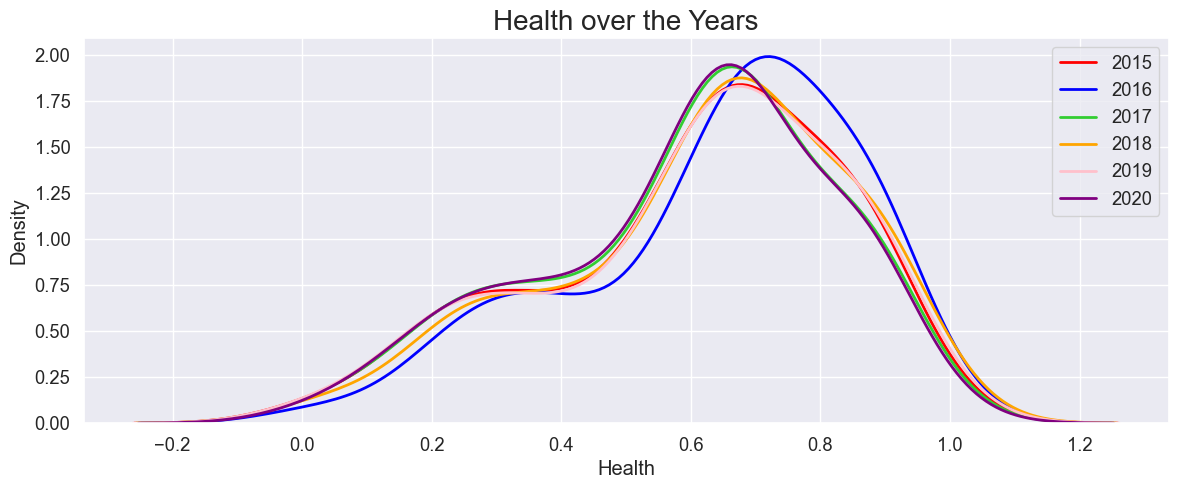

In [8]:
plt.figure(figsize=(14,5))

# 绘制每年的健康数据
sns.kdeplot(data_by_year[2015]['health'], color='red', linewidth=2, label='2015')
sns.kdeplot(data_by_year[2016]['health'], color='blue', linewidth=2, label='2016')
sns.kdeplot(data_by_year[2017]['health'], color='limegreen', linewidth=2, label='2017')
sns.kdeplot(data_by_year[2018]['health'], color='orange', linewidth=2, label='2018')
sns.kdeplot(data_by_year[2019]['health'], color='pink', linewidth=2, label='2019')
sns.kdeplot(data_by_year[2020]['health'], color='purple', linewidth=2, label='2020')

plt.title('Health over the Years', size=20)
plt.legend()  # 添加图例
plt.xlabel('Health')  # x轴标签
plt.ylabel('Density')  # y轴标签
plt.show()


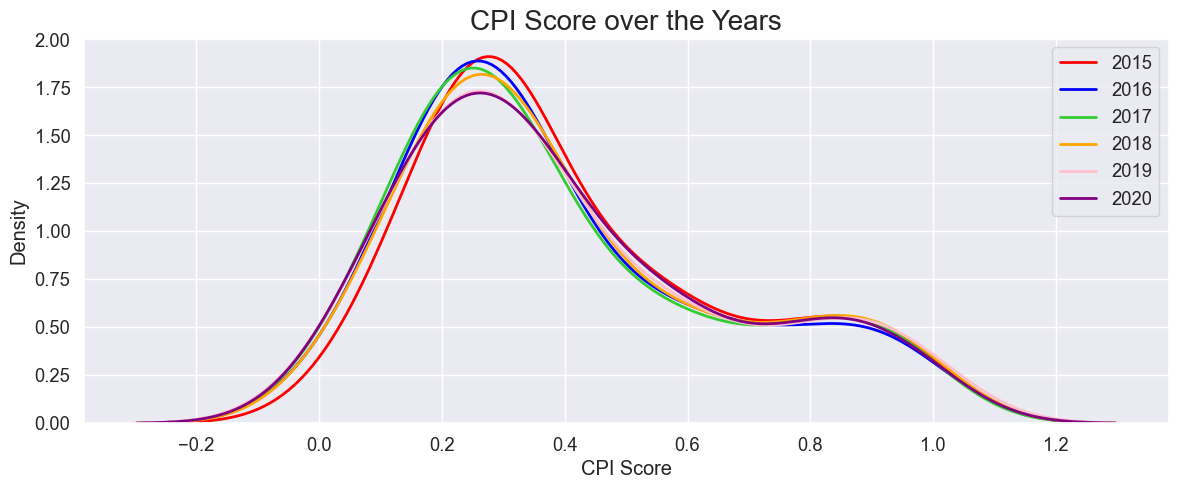

In [9]:
plt.figure(figsize=(14,5))

# 绘制每年的 CPI Score 数据
sns.kdeplot(data_by_year[2015]['cpi_score'], color='red', linewidth=2, label='2015')
sns.kdeplot(data_by_year[2016]['cpi_score'], color='blue', linewidth=2, label='2016')
sns.kdeplot(data_by_year[2017]['cpi_score'], color='limegreen', linewidth=2, label='2017')
sns.kdeplot(data_by_year[2018]['cpi_score'], color='orange', linewidth=2, label='2018')
sns.kdeplot(data_by_year[2019]['cpi_score'], color='pink', linewidth=2, label='2019')
sns.kdeplot(data_by_year[2020]['cpi_score'], color='purple', linewidth=2, label='2020')

plt.title('CPI Score over the Years', size=20)
plt.legend()  # 添加图例
plt.xlabel('CPI Score')  # x轴标签
plt.ylabel('Density')  # y轴标签
plt.show()

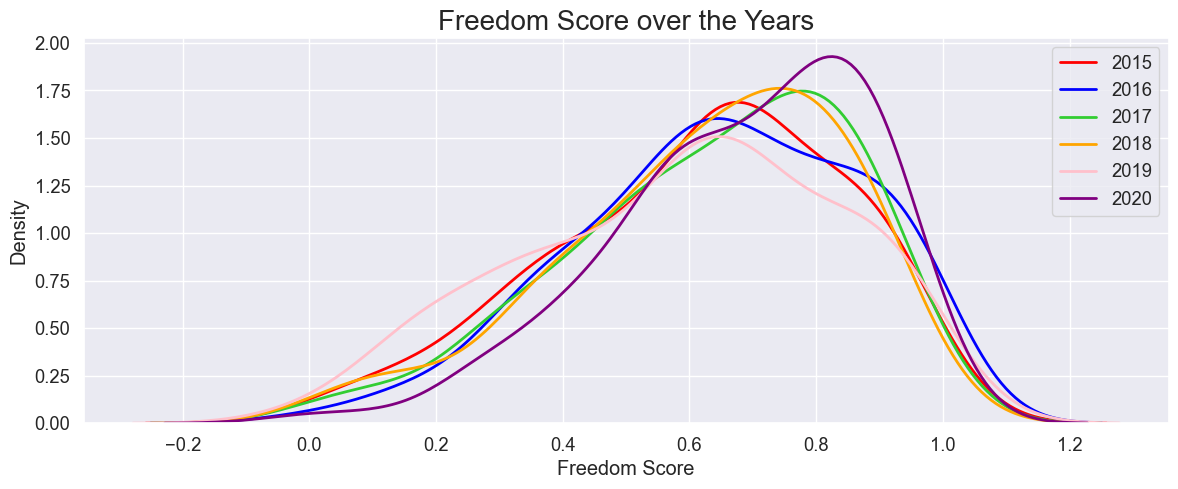

In [10]:
plt.figure(figsize=(14,5))

# 绘制每年的 Freedom 数据
sns.kdeplot(data_by_year[2015]['freedom'], color='red', linewidth=2, label='2015')
sns.kdeplot(data_by_year[2016]['freedom'], color='blue', linewidth=2, label='2016')
sns.kdeplot(data_by_year[2017]['freedom'], color='limegreen', linewidth=2, label='2017')
sns.kdeplot(data_by_year[2018]['freedom'], color='orange', linewidth=2, label='2018')
sns.kdeplot(data_by_year[2019]['freedom'], color='pink', linewidth=2, label='2019')
sns.kdeplot(data_by_year[2020]['freedom'], color='purple', linewidth=2, label='2020')

plt.title('Freedom Score over the Years', size=20)
plt.legend()  # 添加图例
plt.xlabel('Freedom Score')  # x轴标签
plt.ylabel('Density')  # y轴标签
plt.show()


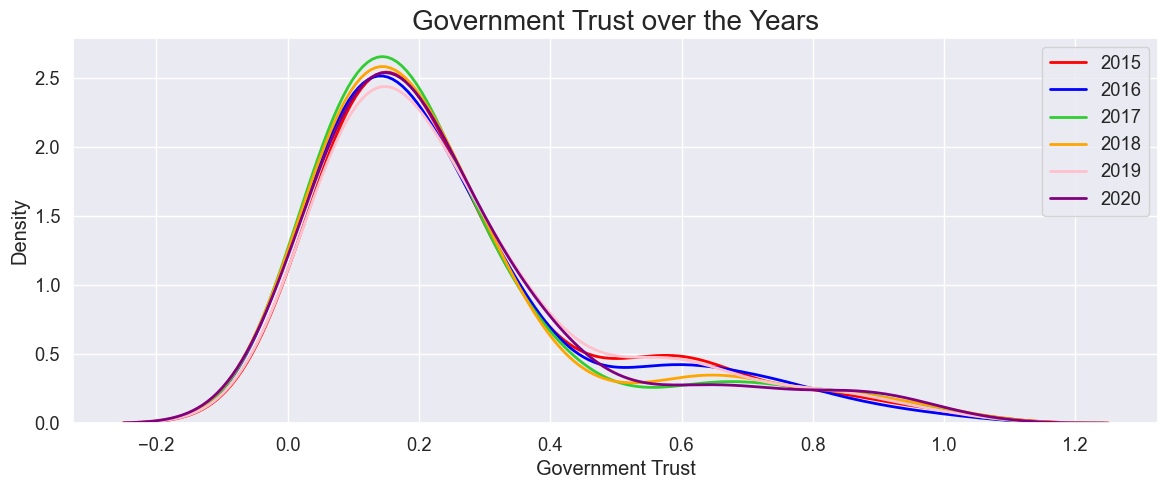

In [11]:
plt.figure(figsize=(14,5))

# 绘制每年的 Government Trust 数据
sns.kdeplot(data_by_year[2015]['government_trust'], color='red', linewidth=2, label='2015')
sns.kdeplot(data_by_year[2016]['government_trust'], color='blue', linewidth=2, label='2016')
sns.kdeplot(data_by_year[2017]['government_trust'], color='limegreen', linewidth=2, label='2017')
sns.kdeplot(data_by_year[2018]['government_trust'], color='orange', linewidth=2, label='2018')
sns.kdeplot(data_by_year[2019]['government_trust'], color='pink', linewidth=2, label='2019')
sns.kdeplot(data_by_year[2020]['government_trust'], color='purple', linewidth=2, label='2020')

plt.title('Government Trust over the Years', size=20)
plt.legend()  # 添加图例
plt.xlabel('Government Trust')  # x轴标签
plt.ylabel('Density')  # y轴标签
plt.show()


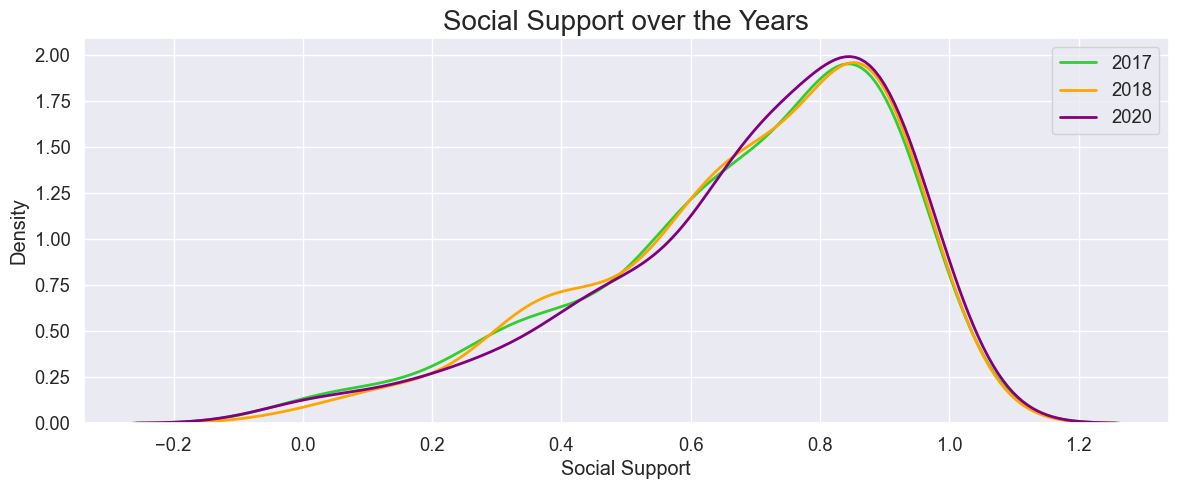

In [12]:
plt.figure(figsize=(14,5))

# 绘制每年的 Social Support 数据
#其中2015,2016,2019年的Social Support 数据全为0
sns.kdeplot(data_by_year[2015]['social_support'], color='red', linewidth=2, label='2015')
sns.kdeplot(data_by_year[2016]['social_support'], color='blue', linewidth=2, label='2016')
sns.kdeplot(data_by_year[2017]['social_support'], color='limegreen', linewidth=2, label='2017')
sns.kdeplot(data_by_year[2018]['social_support'], color='orange', linewidth=2, label='2018')
sns.kdeplot(data_by_year[2019]['social_support'], color='pink', linewidth=2, label='2019')
sns.kdeplot(data_by_year[2020]['social_support'], color='purple', linewidth=2, label='2020')

plt.title('Social Support over the Years', size=20)
plt.legend()  # 添加图例
plt.xlabel('Social Support')  # x轴标签
plt.ylabel('Density')  # y轴标签
plt.show()


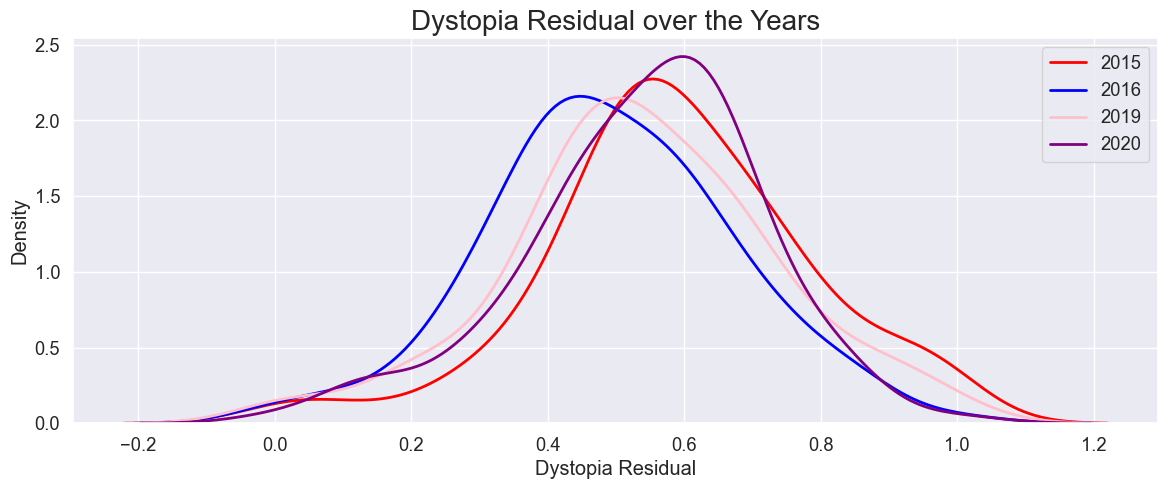

In [13]:
plt.figure(figsize=(14,5))

# 绘制每年的 Dystopia Residual 数据
sns.kdeplot(data_by_year[2015]['dystopia_residual'], color='red', linewidth=2, label='2015')
sns.kdeplot(data_by_year[2016]['dystopia_residual'], color='blue', linewidth=2, label='2016')
sns.kdeplot(data_by_year[2017]['dystopia_residual'], color='limegreen', linewidth=2, label='2017')
sns.kdeplot(data_by_year[2018]['dystopia_residual'], color='orange', linewidth=2, label='2018')
sns.kdeplot(data_by_year[2019]['dystopia_residual'], color='pink', linewidth=2, label='2019')
sns.kdeplot(data_by_year[2020]['dystopia_residual'], color='purple', linewidth=2, label='2020')

plt.title('Dystopia Residual over the Years', size=20)
plt.legend()  # 添加图例
plt.xlabel('Dystopia Residual')  # x轴标签
plt.ylabel('Density')  # y轴标签
plt.show()


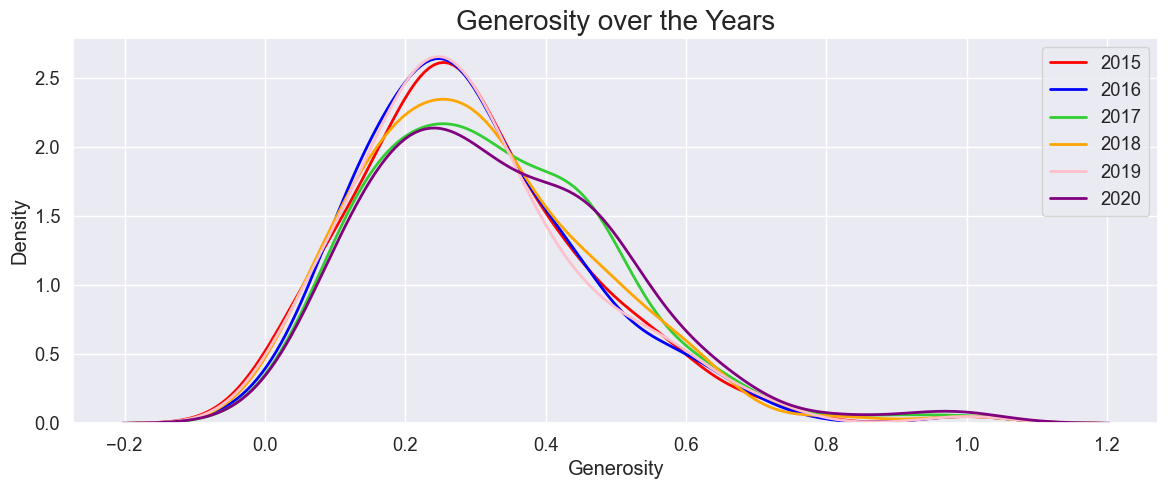

In [14]:
plt.figure(figsize=(14,5))

# 绘制每年的 Generosity 数据
sns.kdeplot(data_by_year[2015]['generosity'], color='red', linewidth=2, label='2015')
sns.kdeplot(data_by_year[2016]['generosity'], color='blue', linewidth=2, label='2016')
sns.kdeplot(data_by_year[2017]['generosity'], color='limegreen', linewidth=2, label='2017')
sns.kdeplot(data_by_year[2018]['generosity'], color='orange', linewidth=2, label='2018')
sns.kdeplot(data_by_year[2019]['generosity'], color='pink', linewidth=2, label='2019')
sns.kdeplot(data_by_year[2020]['generosity'], color='purple', linewidth=2, label='2020')

plt.title('Generosity over the Years', size=20)
plt.legend()  # 添加图例
plt.xlabel('Generosity')  # x轴标签
plt.ylabel('Density')  # y轴标签
plt.show()


In [ ]:
plt.figure(figsize=(14,5))

# 绘制每年的 Family 数据
sns.kdeplot(data_by_year[2015]['family'], color='red', linewidth=2, label='2015')
sns.kdeplot(data_by_year[2016]['family'], color='blue', linewidth=2, label='2016')
sns.kdeplot(data_by_year[2017]['family'], color='limegreen', linewidth=2, label='2017')
sns.kdeplot(data_by_year[2018]['family'], color='orange', linewidth=2, label='2018')
sns.kdeplot(data_by_year[2019]['family'], color='pink', linewidth=2, label='2019')
sns.kdeplot(data_by_year[2020]['family'], color='purple', linewidth=2, label='2020')

plt.title('Family Support over the Years', size=20)
plt.legend()  # 添加图例
plt.xlabel('Family Support')  # x轴标签
plt.ylabel('Density')  # y轴标签
plt.show()

## 聚类分析

### 1. k-means clustering

K-means聚类算法，它是一种经典的无监督学习方法，用于将数据集分成预先确定数量（K个）的簇。该算法的主要思想是通过迭代的方式将数据点划分到与其最近的簇中，并调整簇的中心，直至达到收敛条件。

K-means算法的实现步骤大致如下：
- 初始化：首先，随机选择K个数据点作为初始的簇中心，或者通过其他方式确定初始中心。
- 分配数据点到最近的簇：对于每个数据点，计算其与各个簇中心的距离，并将其分配到距离最近的簇中心所对应的簇。
- 更新簇中心：对每个簇，计算其所有成员数据点的平均值（即新的簇中心）。
- 重复迭代：重复执行步骤2和步骤3，直到满足停止条件（比如簇中心不再改变或达到最大迭代次数）。

K-means算法的优化目标是最小化簇内数据点与其所属簇中心之间的距离，同时最大化不同簇之间的距离。它通常会收敛到局部最优解，并且对初始簇中心的选择敏感。

虽然K-means是一个简单而且易于理解的聚类算法，但在处理非球形、不均匀大小或者有重叠簇的数据集时，可能表现不佳。选择合适的簇数量K也是一个挑战，因为选择不当可能会导致不理想的聚类结果。

#### 1.1 调用sklearn库中的KMeans

参数解释
- n_cluster：聚类个数（即K），默认值是8。
- init：初始化类中心的方法（即选择初始中心点的根据），默认“K-means++”，其他可选参数包括：
“random”。
- n_init：使用不同类中心运行的次数，默认值是10，即算法会初始化10次簇中心，然后返回最好的一次聚类结果。‘auto’ or int, default=’auto’。
- max_iter：单次运行KMeans算法的最大迭代次数，默认值是300。
- tol：浮点型，两次迭代之间簇内平方和下降的容忍阈值，默认为0.0001，如果两次迭代之间下降的值小于tol所设定的值，迭代就会停下。
- verbose:是否输出详细信息，参数类型为整型，默认值为0，1表示每隔一段时间打印一次日志信息。
- random_state：控制每次类中心随机初始化的随机种子，作用相当于能够锁定和复现同一次随机结果，默认为none，也可以随机设置数字。
- copy_x：在预先计算距离时，首先将数据居中在数值上更准确。如果 copy_x 为 True(默认)，则不修改原始数据。如果为 False，则修改原始数据，并在函数返回之前放回，但通过减去再添加数据均值。可能会引入小的数值差异。请注意，如果原始数据不是C-contiguous，即使copy_x 为False，也会进行复制。如果原始数据是稀疏的，但不是 CSR 格式，即使 copy_x 为 False，也会进行复制。
- algorithm：有三种参数可选：auto”, “full”, “elkan”，默认为auto。K-means 算法使用。经典的EM-style算法是“full”。通过使用三角不等式，“elkan” 变体对具有明确定义的集群的数据更有效。然而，由于分配了一个额外的形状数组(n_samples，n_clusters)，它更加占用内存。

In [ ]:
from sklearn.cluster import KMeans

#K means Clustering 
def doKmeans(data, nclust=2, init_method='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto'):
    model = KMeans(n_clusters=nclust, init=init_method, n_init=n_init, max_iter=max_iter, tol=tol, verbose=verbose, random_state=random_state, copy_x=copy_x, algorithm=algorithm)
    start_time = time.time()
    model.fit(data)
    clust_labels = model.predict(data)
    end_time = time.time()
    cost_time = end_time - start_time
    cent = model.cluster_centers_
    return clust_labels, cent, cost_time


##### 实验1 确定最佳K值

当使用K-means聚类算法时，确定最佳的簇数量（K）的一个常用方法是通过手肘法（Elbow Method）来进行估计。手肘法尝试在不同的K值下观察簇内平方和的变化情况，帮助找到一个最佳的K值。

使用手肘法确定最佳K值的一般步骤：
- 计算簇内平方和（inertia）：对于不同的K值（比如从1到10），分别运行K-means算法并计算每个K值下的簇内平方和。簇内平方和是指数据点到其所属簇中心的距离的平方和。

- 绘制手肘法图表：将不同K值下的簇内平方和（inertia）绘制成一张折线图。

- 找到拐点（elbow）：观察折线图，在K值逐渐增加时，簇内平方和会逐渐减小。但是在某个K值之后，进一步增加K值所带来的簇内平方和下降幅度会减缓，形成一个类似“手肘”的拐点。

- 选择拐点处的K值：选择拐点处对应的K值作为最佳的簇数量。这个K值通常被视为平衡了簇内紧密度和模型复杂度的最佳选择。

In [ ]:
years = range(2015, 2021)

plt.figure(figsize=(10, 6))
sns.set(style='darkgrid')  # 设置Seaborn风格为白色网格

for year in years:
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data_by_year[year])
        sse.append(kmeans.inertia_)
    
    plt.plot(range(1, 11), sse, marker='o', label=f'{year}', linewidth=1.5)  # 调整线条粗细

plt.xlabel('Number of clusters (K)', fontsize=12)  # 调整字体大小
plt.ylabel('Sum of squared distances', fontsize=12)
plt.title('Elbow Method for Optimal K', fontsize=14)
plt.legend()
plt.grid(True)  # 显示网格线
plt.tight_layout()
plt.show()



在2015-2020年数据的手肘法图中，随着簇数量（K）增加，簇内平方和逐渐减小。然而，关键观察是都在K=3处出现了一个明显的“肘部”，这意味着进一步增加K值后，簇内平方和的减少速度减缓。因此，基于手肘法，选择K=3可以平衡模型复杂度和保持足够低的簇内方差，是一个合适的选择。

##### 实验2 对比初始聚类中心的两种不同方法K-means++和random

1. K-means++（K均值++）：

    K-means++是一种智能选择初始聚类中心的方法。它通过以下步骤选择初始中心点：

      - 首先，从数据集中随机选择一个点作为第一个聚类中心。

      - 然后，在选择后续的初始中心时，它会考虑到已经选择的中心点，并倾向于选择距离现有中心较远的点作为新的初始中心。这样做可以增加初始中心点的广泛性，提高算法收敛速度和聚类效果。



In [ ]:
#以2015年的数据为例
#2015年的
clust_labels, cent, cost_time = doKmeans(data_by_year[2015], 3, 'k-means++')
kmeans0 = pd.DataFrame(clust_labels)


In [ ]:
#Plot the clusters obtained using k means
# 绘制散点图
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(data_by_year[2015]['gdp_per_capita'], data_by_year[2015]['health'],
                        c=kmeans0[0], s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('GDP per Capita')
ax.set_ylabel('Health')
plt.colorbar(scatter)

# 添加消耗时间的文本
text = f'Clustering took {cost_time:.2f} s'  # 格式化文本
ax.text(-0.3, -0.3, text, transform=ax.transAxes, fontsize=12, color='blue')  # 在图表底部添加文本
plt.show()


2. Random（随机选择）：
   
    Random方法简单地从数据集中随机选择初始的K个中心点作为聚类的起始点。

    相比K-means++，这种方法选择中心点的方式更为随机，不考虑数据间的距离或分布情况。

In [ ]:
#以2015年的数据为例
#2015年的
clust_labels, cent, cost_time = doKmeans(data_by_year[2015], 3, 'random')
kmeans1 = pd.DataFrame(clust_labels)

In [ ]:
#Plot the clusters obtained using k means
# 绘制散点图
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(data_by_year[2015]['gdp_per_capita'], data_by_year[2015]['health'],
                        c=kmeans1[0], s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('GDP per Capita')
ax.set_ylabel('Health')
plt.colorbar(scatter)

# 添加消耗时间的文本
text = f'Clustering took {cost_time:.2f} s'  # 格式化文本
ax.text(-0.3, -0.3, text, transform=ax.transAxes, fontsize=12, color='blue')  # 在图表底部添加文本
plt.show()

通过对比实验得到结论：

K-means++结果：

- 使用K-means++方法初始化聚类中心得到的聚类结果可能更加稳定和可靠。它能够更有效地选择初始中心点，有助于更快地达到收敛状态。
- 散点图展示了基于GDP per Capita和Health两个特征的聚类结果。不同颜色的点表示不同的聚类簇，能够更好地划分数据点。
  
Random结果：

- 使用随机方法初始化聚类中心可能会导致结果的不稳定性和随机性。不同运行中的聚类效果可能有所不同。
- 散点图可能显示出不同的聚类分布，但随机初始化可能使得算法更容易收敛到局部最优解，因此聚类结果可能不够稳定或合理。
  
总的来说，K-means++方法在选择初始聚类中心时更加智能和可靠，可能会得到更好的聚类效果，而随机方法可能导致结果的不确定性和随机性。因此，针对这个数据集和特定的特征，K-means++可能是更好的选择。

##### 实验3 对比三种algorithm：“auto”, “full”, “elkan”

- "auto"：这个选项会根据数据的特性和K-means的限制来自动选择最合适的算法。通常，如果输入数据是稠密的，它会选择"elkan"算法，如果输入数据是稀疏的，它会选择"full"算法。它会根据数据的结构自动调整以获得最佳的性能。

- "full"：这是传统的K-means算法，也称为EM算法（期望最大化算法）。它通过迭代计算聚类中心，并将每个样本分配到最近的中心，然后重新计算新的中心。这个过程持续迭代，直到收敛到最终的聚类。

- "elkan"：这是一种改进的K-means算法，通过使用三角不等式来加速计算。它通过减少数据点之间距离的计算来提高效率，特别适用于具有明确定义的簇的数据。然而，它需要分配额外的内存来保存数据点之间的距离信息。

这些算法在不同的数据集和数据结构下表现可能会有所不同。一般来说，“auto”选项是一个很好的默认选择，因为它会根据数据的性质自动选择最佳算法。如果你知道数据的稠密程度或者数据集的特点，可以手动选择更合适的算法以提高性能。






In [ ]:
# 进行对比实验
algorithms = ['auto', 'full', 'elkan']
results = {}

for algorithm in algorithms:
    clust_labels, cent, cost_time = doKmeans(data_by_year[2015], nclust=3, algorithm=algorithm)
    results[algorithm] = {'labels': clust_labels, 'centroids': cent, 'time': cost_time}

# 绘制聚类结果的散点图和比较时间消耗
fig, axs = plt.subplots(1, len(algorithms), figsize=(15, 5))

for i, (algorithm, result) in enumerate(results.items()):
    labels = result['labels']
    centroids = result['centroids']
    cost_time = result['time']
    
    axs[i].scatter(data_by_year[2015]['gdp_per_capita'], data_by_year[2015]['health'], c=labels, cmap='viridis', s=50)
    axs[i].scatter(centroids[:, 0], centroids[:, 1], marker='x', c='red', s=200, label='Centroids')
    axs[i].set_title(f'K-Means Clustering with {algorithm}')
    axs[i].set_xlabel('GDP per Capita')
    axs[i].set_ylabel('Health')
    axs[i].legend()
    
    text = f'Clustering took {cost_time:.2f} s'
    axs[i].text(-0.3, -0.3, text, transform=axs[i].transAxes, fontsize=10, color='blue')

plt.tight_layout()
plt.show()

##### 实验四 绘制聚类结果图时，展示不同变量之间的聚类结果

In [ ]:
#2015年的
clust_labels, cent, cost_time = doKmeans(data_by_year[2015], 3)
kmeans_label = pd.DataFrame(clust_labels)

In [ ]:
import itertools

# 属性列表
attributes = ['gdp_per_capita', 'health', 'cpi_score', 'freedom', 'government_trust', 'social_support',
                'dystopia_residual', 'generosity', 'family']

# 创建所有可能的属性组合
attribute_combinations = list(itertools.combinations(attributes, 2))

# 计算要绘制的子图的行数和列数
num_rows = int(np.ceil(len(attribute_combinations) / 3))  # 每行3个子图
num_cols = 3

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(14, 3*num_rows),
                            gridspec_kw={'hspace': 0.4, 'wspace': 0.4})  # 设置子图间隔

for idx, (x_attr, y_attr) in enumerate(attribute_combinations):
    row = idx // num_cols
    col = idx % num_cols
    
    ax = axes[row, col]
    scatter = ax.scatter(data_by_year[2015][x_attr], data_by_year[2015][y_attr], c=kmeans_label[0], s=15, cmap='viridis')
    ax.set_title(f'K-Means Clustering ({x_attr} vs {y_attr})', fontsize=10)
    ax.set_xlabel(x_attr, fontsize=8)
    ax.set_ylabel(y_attr, fontsize=8)
    plt.colorbar(scatter, ax=ax)
    ax.text(0.05, 0.05, f'Clustering took {cost_time:.2f} s', transform=ax.transAxes, fontsize=6, color='blue')

# 隐藏多余的子图
for i in range(len(attribute_combinations), num_rows*num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()



通过观察这36张图，可以得到以下观察和结论：

- 区分度：有些属性组合能够很好地区分出3个类别，而另一些属性组合则可能无法清晰地将3个簇分开。

- 相关性：某些属性组合可能具有更高的相关性，导致散点图上的数据点呈现出更线性的分布，这可能不利于K-means聚类算法将数据点分为不同的簇。

- 聚类效果：对于那些三个簇挤在一起的情况，可能是因为选择的属性组合不够有效地反映了数据集的聚类结构。也有可能是由于数据本身的特点，比如在某些属性组合下，数据点本身就难以区分开。

- 数据空间：对于表现良好的属性组合，可以观察到数据点在二维空间中明显地形成了3个簇；而在一些图表中，可能会看到簇之间的分离度较差，数据点混合在一起，这可能暗示着K-means在这些情况下的聚类效果较差。

#### 1.2 自实现k-means

- fit_model()函数：用于训练模型，执行多次迭代以更新聚类中心。
- plot_kmeans()：函数绘制了聚类结果的散点图。
- predict()函数：返回预测结果，包括最终的聚类结果和中心点。
- plot_elbow()函数：实现了肘部法则来帮助确定最优的聚类数量。

In [ ]:
import random as rd
class myKMeans(object):

    def __init__(self, df, K, x_label, y_label):
        self.data = df.values
        self.x_label = x_label
        self.y_label =  y_label
        self.K = K                      # num clusters
        self.m = self.data.shape[0]     # num training examples
        self.n = self.data.shape[1]     # num of features
        self.result = {}
        self.centroids = np.array([]).reshape(self.n, 0)

    #初始化随机聚类中心
    def init_random_centroids(self):
        temp_centroids = np.array([]).reshape(self.n, 0)
        for i in range(self.K):
            rand = rd.randint(0, self.m-1)
            temp_centroids = np.c_[temp_centroids, self.data[rand]]

        return temp_centroids


    def fit_model(self, num_iter):
        # 初始化随机聚类中心
        self.centroids = self.init_random_centroids()
        # 开始迭代更新聚类中心，计算并更新欧氏距离
        for i in range(num_iter):
            # 首先计算欧氏距离并存储到数组中
            EucDist = np.array([]).reshape(self.m, 0)
            for k in range(self.K):
                dist = np.sum((self.data - self.centroids[:,k])**2, axis=1)
                EucDist = np.c_[EucDist, dist]
            # 取最小距离
            min_dist = np.argmin(EucDist, axis=1) + 1

            # 开始迭代
            soln_temp = {} # 临时字典，存储每次迭代的解决方案

            for k in range(self.K):
                soln_temp[k+1] = np.array([]).reshape(self.n, 0)

            for i in range(self.m):
                # 根据聚类索引重新分组数据点
                soln_temp[min_dist[i]] = np.c_[soln_temp[min_dist[i]], self.data[i]]

            for k in range(self.K):
                soln_temp[k+1] = soln_temp[k+1].T

            # 更新聚类中心为每个聚类的新均值
            for k in range(self.K):
                self.centroids[:,k] = np.mean(soln_temp[k+1], axis=0)

            self.result = soln_temp


    def plot_kmeans(self):
        # create arrays for colors and labels based on specified K
        colors = ["#"+''.join([rd.choice('0123456789ABCDEF') for j in range(6)]) \
                    for i in range(self.K)]
        labels = ['cluster_' + str(i+1) for i in range(self.K)]

        fig1 = plt.figure(figsize=(5,5))
        ax1 = plt.subplot(111)
        # plot each cluster
        for k in range(self.K):
                ax1.scatter(self.result[k+1][:,0], self.result[k+1][:,1],
                                        c = colors[k], label = labels[k])
        # plot centroids
        ax1.scatter(self.centroids[0,:], self.centroids[1,:], #alpha=.5,
                                s = 300, c = 'lime', label = 'centroids')
        plt.xlabel(self.x_label) # first column of df
        plt.ylabel(self.y_label) # second column of df
        plt.title('Plot of K Means Clustering Algorithm')
        plt.legend()

        return plt.show(block=True)


    def predict(self):
        """
        result:每个中心点的最小欧氏距离。
        centroids.T:迭代n次后的K个中心点。
        """
        return self.result, self.centroids.T


    def plot_elbow(self):
        """
        Elbow Method:
        The elbow method will help us determine the optimal value for K.
        Steps:
        1) Use a range of K values to test which is optimal
        2) For each K value, calculate Within-Cluster-Sum-of-Squares (WCSS)
        3) Plot Num Clusters (K) x WCSS

        Returns
        -------
        plot
            elbow plot - k values vs wcss values to find optimal K value.
        """

        wcss_vals = np.array([])
        for k_val in range(1, self.K):
            results, centroids = self.predict()
            wcss=0
            for k in range(k_val):
                wcss += np.sum((results[k+1] - centroids[k,:])**2)
            wcss_vals = np.append(wcss_vals, wcss)
        # Plot K values vs WCSS values
        K_vals = np.arange(1, self.K)
        plt.plot(K_vals, wcss_vals)
        plt.xlabel('K Values')
        plt.ylabel('WCSS')
        plt.title('Elbow Method')

        return plt.show(block=True)

In [ ]:
kmeans = myKMeans(data_by_year[2020], 3,'gdp_per_capita','health') 
kmeans.fit_model(100) # 100 iterations
kmeans.plot_kmeans() 
results, centroids = kmeans.predict()

print(results)
print()
print(centroids)

### 2. Hierarchical clustering

Hierarchical clustering层次聚类存在两种：凝聚式（Agglomerative）和分裂式（Divisive）。

#### 2.1 Agglomerative Clustering

Agglomerative Clustering：这种方法从每个数据点开始，将每个点作为一个独立的簇，然后逐步合并具有最小距离或相似度的簇，直到达到某种终止条件，例如簇的数量或某个阈值。在每个合并步骤中，最相似的两个簇会被合并成一个新的簇，这个过程会持续直到所有点被合并为一个簇。

Agglomerative Clustering层次聚类的过程：

- 初始化：将每个数据点视为一个独立的簇。
- 计算相似度/距离：计算所有点对之间的相似度或距离矩阵。
- 合并最相似的簇：根据相似度或距离选择最相似的两个簇进行合并，形成一个新的簇。
- 更新相似度/距离矩阵：重新计算合并后的簇与其他簇的相似度或距离。
- 重复合并步骤：不断重复步骤3和步骤4，直到满足停止条件（如达到指定的簇数量）。
- 生成层次聚类树：在合并的过程中记录簇的合并顺序，可以用于生成聚类树（树状图）。

##### 2.1.1 调用sklearn实现
参数解释：

- n_clusters（整数或None，默认为2）：要查找的聚类数量。如果distance_threshold不为None，则此值必须为None。
- metric（字符串或可调用对象，默认为“euclidean”）：用于计算链接的度量标准。可以是“euclidean”（欧式距离）、“l1”（曼哈顿距离）、“l2”（欧几里得距离）、“manhattan”（曼哈顿距离）、“cosine”（余弦相似度）或“precomputed”（预先计算的距离矩阵）。如果链接是“ward”，则只接受“euclidean”。如果是“precomputed”，则需要将距离矩阵作为fit方法的输入。
- memory（字符串或实现了joblib.Memory接口的对象，默认为None）：用于缓存树计算输出结果。默认情况下，不进行缓存。如果给出字符串，则为缓存目录的路径。
- connectivity（类数组或可调用对象，默认为None）：连接矩阵。为数据集中的每个样本定义了相邻样本的结构。可以是连接矩阵本身，也可以是一个可调用对象，将数据转换为连接矩阵，例如从kneighbors_graph得出的矩阵。默认为None，即层次聚类算法无结构性。
- compute_full_tree（‘auto’或布尔值，默认为’auto’）：在n_clusters处提前停止树的构建。如果聚类数目与样本数目相比较大，这对减少计算时间是有帮助的。这个选项只在指定了连接矩阵时才有效。如果distance_threshold不是None，则必须为True。默认情况下，当distance_threshold不为None或n_clusters小于100或0.02 * n_samples的最大值时，compute_full_tree为“auto”，相当于True。否则，“auto”相当于False。
- linkage（{‘ward’，‘complete’，‘average’，‘single’}，默认为’ward’）：用于决定两组观测值之间距离的连接标准。算法将合并最小化此标准的聚类对。
- distance_threshold（浮点数，默认为None）：聚类不会合并的链接距离阈值。如果不为None，则n_clusters必须为None，并且compute_full_tree必须为True。
- compute_distances（布尔值，默认为False）：即使不使用distance_threshold，也会计算簇之间的距离。这可用于制作树状图可视化，但会增加计算和内存开销。

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Agglomerative Clustering

def doAgglomerativeClustering(data, n_clusters=3, linkage='ward', affinity='euclidean'):
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, affinity=affinity)
    start_time = time.time()
    clust_labels = model.fit_predict(data)
    end_time = time.time()
    cost_time = end_time - start_time
    return (clust_labels, cost_time)


##### 实验一 确定聚类簇的数量

确定聚类数量：

1. 树状图突变点（Dendrogram Elbow）：寻找树状图中垂直线的高度出现急剧变化的位置。这个变化点通常代表了合适的聚类数量。高度差异较大的垂直线表示了合并簇时距离的剧烈变化，可以作为聚类数量的参考。

2. 树状图高度切割：在树状图中，以某个高度切断树，得到相应数量的聚类。这个高度可以作为聚类数量的选择。

In [ ]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(data_by_year[2015], method='ward'))

# 添加垂直线或高度标记

plt.axhline(y=10, color='r', linestyle='--', label='Cluster count criterion')

plt.legend()
plt.show()


找到最佳簇数的方法是识别簇间距离突然变化的点。 这称为“拐点”或“肘点”，可用于确定最能捕捉数据变化的聚类数量。 上面图中我们可以看到，不同数量的簇之间的最大距离变化发生在 2 和 3 个簇之间。 因此，说明最佳簇数是三个。



##### 实验二 对比四种linkage:'ward','complete','average','single'

1. Ward Linkage：这种方法基于两个簇合并后的总方差来衡量簇与簇之间的距离。它试图最小化每个簇内的方差增加量，从而产生更加紧凑和凝聚的簇。
2. Complete Linkage：这个方法计算两个簇中最远两个点之间的距离，然后把这个最大距离作为两个簇之间的距离。这会产生具有更明显分离的簇。
3. Average Linkage：平均连接是计算两个簇中所有点对之间距离的平均值作为簇与簇之间的距离。它相对于单连接和完全连接提供了一种中庸的方法。
4. Single Linkage：这种方法通过计算两个簇中最接近的两个点之间的距离，然后把这个最小距离作为两个簇之间的距离。它对噪音和异常值更加敏感，可能会导致链式效应。

这些链接标准会影响层次聚类的结果，不同的方法可能适用于不同类型的数据结构和聚类问题。通过尝试不同的链接标准，可以观察到在数据集上形成的不同聚类结构。

In [ ]:
# 进行层次聚类
linkage_methods = ['ward', 'complete', 'average', 'single']
results = {}

# 对每种链接标准进行聚类，并可视化结果
for method in linkage_methods:
    clust_labels, cost_time = doAgglomerativeClustering(data_by_year[2015], linkage=method)
    results[method] = {'labels': clust_labels, 'time': cost_time}

# 绘制聚类结果的散点图和比较时间消耗
fig, axs = plt.subplots(1, len(linkage_methods), figsize=(14, 4))

for i, (method, result) in enumerate(results.items()):
    labels = result['labels']
    cost_time = result['time']
    
    axs[i].scatter(data_by_year[2015]['gdp_per_capita'], data_by_year[2015]['cpi_score'], c=labels, cmap='viridis', s=50, label='Cluster')
    axs[i].set_title(f'Agglomerative Clustering with {method}')
    axs[i].set_xlabel('GDP per Capita')
    axs[i].set_ylabel('Cpi_score')
    
    text = f'Clustering took {cost_time:.2f} s'
    axs[i].text(-0.3, -0.3, text, transform=axs[i].transAxes, fontsize=10, color='blue')

plt.tight_layout()
plt.show()


##### 实验三 对比三种距离度量affinity:'euclidean', 'manhattan', 'cosine'

In [ ]:
# 进行层次聚类，尝试不同距离度量
affinities = ['euclidean', 'manhattan', 'cosine']
results_aff = {}

for aff in affinities:
    clust_labels, cost_time = doAgglomerativeClustering(data_by_year[2015], linkage='average', affinity=aff)
    results_aff[aff] = {'labels': clust_labels, 'time': cost_time}

# 绘制聚类结果的散点图和比较时间消耗
fig, axs = plt.subplots(1, len(affinities), figsize=(16, 4))

for i, (aff, result) in enumerate(results_aff.items()):
    labels = result['labels']
    cost_time = result['time']
    
    axs[i].scatter(data_by_year[2015]['gdp_per_capita'], data_by_year[2015]['cpi_score'], c=labels, cmap='viridis', s=50, label='Cluster')
    axs[i].set_title(f'Agglomerative Clustering with Ward Linkage and {aff} Distance')
    axs[i].set_xlabel('GDP per Capita')
    axs[i].set_ylabel('Cpi_score')
    
    text = f'Clustering took {cost_time:.2f} s'
    axs[i].text(-0.3, -0.3, text, transform=axs[i].transAxes, fontsize=10, color='blue')

plt.tight_layout()
plt.show()

##### 实验四 绘制聚类结果图，展示不同变量之间的聚类结果

In [ ]:
#2015年的
clust_labels, cost_time = doAgglomerativeClustering(data_by_year[2015], 3)
Agglomerative = pd.DataFrame(clust_labels)


In [ ]:
import itertools

# 属性列表
attributes = ['gdp_per_capita', 'health', 'cpi_score', 'freedom', 'government_trust', 'social_support',
                'dystopia_residual', 'generosity', 'family']

# 创建所有可能的属性组合
attribute_combinations = list(itertools.combinations(attributes, 2))

# 计算要绘制的子图的行数和列数
num_rows = int(np.ceil(len(attribute_combinations) / 3))  # 每行3个子图
num_cols = 3

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(14, 3*num_rows),
                            gridspec_kw={'hspace': 0.4, 'wspace': 0.4})  # 设置子图间隔

for idx, (x_attr, y_attr) in enumerate(attribute_combinations):
    row = idx // num_cols
    col = idx % num_cols
    
    ax = axes[row, col]
    scatter = ax.scatter(data_by_year[2015][x_attr], data_by_year[2015][y_attr], c=Agglomerative[0], s=15, cmap='viridis')
    ax.set_title(f'Agglomerative Clustering ({x_attr} vs {y_attr})', fontsize=10)
    ax.set_xlabel(x_attr, fontsize=8)
    ax.set_ylabel(y_attr, fontsize=8)
    plt.colorbar(scatter, ax=ax)
    ax.text(0.05, 0.05, f'Clustering took {cost_time:.2f} s', transform=ax.transAxes, fontsize=6, color='blue')

# 隐藏多余的子图
for i in range(len(attribute_combinations), num_rows*num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

#### 2.1.2 自实现Agglomerative Clustering

##### Cluster similarity measures

两个聚类 $C_i, C_j$ 的相似性由一个距离度量确定。

##### Single link

![equation](https://latex.codecogs.com/svg.image?%5Cinline%20%5Cbg%7Bblue%7D%7B%5Ccolor%7BOrange%7D%20D(C_i%20,%20C_j)%20=%20min%5C%7Bd(v_p%20,%20v_q)%20%7C%20v_p%20%5Cin%20C_i%20,%20v_q%20%5Cin%20C_j%5C%7D%7D)
<img src="https://latex.codecogs.com/svg.image?%5Cinline%20%5Cbg%7Bblue%7D%7B%5Ccolor%7BOrange%7D%20D(C_i%20,%20C_j)%20=%20min%5C%7Bd(v_p%20,%20v_q)%20%7C%20v_p%20%5Cin%20C_i%20,%20v_q%20%5Cin%20C_j%5C%7D%7D">

##### Complete_link

![equation](https://latex.codecogs.com/svg.image?%5Cinline%20%5Cbg%7Bblue%7D%7B%5Ccolor%7BOrange%7D%20D(C_i%20,%20C_j)%20=%20max%5C%7Bd(v_p%20,%20v_q)%20%7C%20v_p%20%5Cin%20C_i%20,%20v_q%20%5Cin%20C_j%5C%7D%7D)

##### Average link

![equation](https://latex.codecogs.com/svg.image?%5Cinline%20%5Cbg%7Bblue%7D%7B%5Ccolor%7BOrange%7D%20D(C_i%20,%20C_j)%20=%20mean%5C%7Bd(v_p%20,%20v_q)%20%7C%20v_p%20%5Cin%20C_i%20,%20v_q%20%5Cin%20C_j%5C%7D%7D)

距离越小，两个聚类越相似。在方程中，d() 是两个数据点之间的距离度量，即欧氏距离，由以下公式定义：
![equation](https://latex.codecogs.com/svg.image?%5Cinline%20%5Cbg%7Bblue%7D%7B%5Ccolor%7BOrange%7D%20d(p%20,%20q)%20=%5Csqrt%7B%5Csum_%7Bi%7D%5E%7B%7D%20(p_i%20-%20p_j)%5E2%7D%7D)
其中 p_i, q_i 是 p, q 的维度。

In [ ]:
import math


def distance(p, q):
    return math.sqrt(sum([(pi - qi)**2 for pi, qi in zip(p, q)]))


def single_link(ci, cj):
    return min([distance(vi, vj) for vi in ci for vj in cj])


def complete_link(ci, cj):
    return max([distance(vi, vj) for vi in ci for vj in cj])


def average_link(ci, cj):
    distances = [distance(vi, vj) for vi in ci for vj in cj]
    return sum(distances) / len(distances)


def get_distance_measure(M):
    if M == 0:
        return single_link
    elif M == 1:
        return complete_link
    else:
        return average_link


- __init__: 初始化方法，接受数据、期望的聚类数(K)，以及距离度量方式(M)。
- init_clusters: 初始化聚类簇，每个数据点作为一个初始簇。
- find_closest_clusters: 找到距离最近的两个簇。
- merge_and_form_new_clusters: 合并两个最近的簇，并形成新的簇集合。
- run_algorithm: 运行层次聚类算法，迭代合并簇直到达到期望的聚类数。
- print: 打印每个簇的数据点。

In [ ]:
class myAgglomerativeHierarchicalClustering:
    def __init__(self, data, K, M):
        self.data = data
        self.N = len(data)
        self.K = K
        self.measure = get_distance_measure(M)
        self.clusters = self.init_clusters()

    def init_clusters(self):
        return {data_id: [data_point] for data_id, data_point in enumerate(self.data)}

    #找到距离最近的两个簇
    def find_closest_clusters(self):
        min_dist = math.inf
        closest_clusters = None

        clusters_ids = list(self.clusters.keys())

        for i, cluster_i in enumerate(clusters_ids[:-1]):
            for j, cluster_j in enumerate(clusters_ids[i+1:]):
                dist = self.measure(self.clusters[cluster_i], self.clusters[cluster_j])
                if dist < min_dist:
                    min_dist, closest_clusters = dist, (cluster_i, cluster_j)
        return closest_clusters

    #合并最近的两个簇，并形成新的簇集合
    def merge_and_form_new_clusters(self, ci_id, cj_id):
        new_clusters = {0: self.clusters[ci_id] + self.clusters[cj_id]}

        for cluster_id in self.clusters.keys():
            if (cluster_id == ci_id) | (cluster_id == cj_id):
                continue
            new_clusters[len(new_clusters.keys())] = self.clusters[cluster_id]
        return new_clusters

    def run_algorithm(self):
        while len(self.clusters.keys()) > self.K:
            closest_clusters = self.find_closest_clusters()
            self.clusters = self.merge_and_form_new_clusters(*closest_clusters)
            
        # 将每行数据分配到对应的簇，并将结果返回
        cluster_labels = []

        for data_point in self.data:
            matched = False  # 用于记录是否找到了匹配的点
            for cluster_id, points in self.clusters.items():
                for point in points:
                    if np.array_equal(data_point, point):
                        cluster_labels.append(cluster_id)
                        matched = True  # 找到匹配的点
                        break
                if matched:
                    break  # 如果找到了匹配的点，跳出内层循环
            # 如果没有找到匹配的点，添加一个标志值
            if not matched:
                cluster_labels.append(-1)  # 或者使用其他指示未匹配的值
                
        return cluster_labels


    def print(self):
        for id, points in self.clusters.items():
            print("Cluster: {}".format(id))
            for point in points:
                print("    {}".format(point))


##### 实验五 自实现三种measure的对比

(1) single_link

In [ ]:
agg_hierarchical_clustering = myAgglomerativeHierarchicalClustering(data_by_year[2015].values, 3, 0)
clust_labels=agg_hierarchical_clustering.run_algorithm()
# agg_hierarchical_clustering.print()
print(clust_labels)

myAgglomerative = pd.DataFrame(clust_labels)
# data_by_year[2018].insert((data_by_year[2018].shape[1]),'Agglomerative',myAgglomerative)

In [ ]:
# 绘制散点图
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(data_by_year[2015]['gdp_per_capita'], data_by_year[2015]['cpi_score'],
                        c=myAgglomerative[0], s=50)
ax.set_title('Agglomerative Clustering')
ax.set_xlabel('GDP per Capita')
ax.set_ylabel('Cpi_score')
plt.colorbar(scatter)

ax.text(-0.3, -0.3, text, transform=ax.transAxes, fontsize=12, color='blue')  # 在图表底部添加文本
plt.show()

(2) complete_link

In [ ]:
agg_hierarchical_clustering = myAgglomerativeHierarchicalClustering(data_by_year[2015].values, 3, 1)
clust_labels1=agg_hierarchical_clustering.run_algorithm()
# agg_hierarchical_clustering.print()
print(clust_labels1)

myAgglomerative1 = pd.DataFrame(clust_labels1)

In [ ]:
# 绘制散点图
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(data_by_year[2015]['gdp_per_capita'], data_by_year[2015]['cpi_score'],
                        c=myAgglomerative1[0], s=50)
ax.set_title('Agglomerative Clustering')
ax.set_xlabel('GDP per Capita')
ax.set_ylabel('Cpi_score')
plt.colorbar(scatter)

ax.text(-0.3, -0.3, text, transform=ax.transAxes, fontsize=12, color='blue')  # 在图表底部添加文本
plt.show()

(3) average_link

In [ ]:
agg_hierarchical_clustering = myAgglomerativeHierarchicalClustering(data_by_year[2018].values, 3, 2)
clust_labels2=agg_hierarchical_clustering.run_algorithm()
# agg_hierarchical_clustering.print()
print(clust_labels2)

myAgglomerative2 = pd.DataFrame(clust_labels2)

In [ ]:
# 绘制散点图
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(data_by_year[2015]['gdp_per_capita'], data_by_year[2015]['cpi_score'],
                        c=myAgglomerative2[0], s=50)
ax.set_title('Agglomerative Clustering')
ax.set_xlabel('GDP per Capita')
ax.set_ylabel('Cpi_score')
plt.colorbar(scatter)

ax.text(-0.3, -0.3, text, transform=ax.transAxes, fontsize=12, color='blue')  # 在图表底部添加文本
plt.show()

#### 2.2 Divisive Clustering

#### 2.3 Birch Clustering

Birch Clustering (Balanced Iterative Reducing and Clustering using Hierarchies) 是层次聚类的典型代表，通过在树状结构中构建聚类来减少数据集的维数。
Birch算法的主要思想是通过构建一棵层次化的聚类树来对数据进行聚类。该算法通过两个主要步骤来实现聚类：构建聚类树和划分数据。在构建聚类树的过程中，Birch算法使用了两个重要的数据结构：CF（Clustering Feature）和CF Tree（Clustering Feature Tree）。CF是对数据点的累积统计信息，包括数据点的数量、均值和方差。CF Tree是一个用于存储CF的树状结构，其中每个节点都包含一个CF和指向子节点的指针。Birch算法首先将数据点插入到CF Tree中，然后根据一些阈值对CF Tree进行压缩。压缩操作将相似的CF合并成一个更大的CF，从而减少树的大小。这个过程会递归地进行，直到满足一些停止准则。在划分数据的过程中，Birch算法将CF Tree划分成一组子簇。划分的依据是CF Tree中节点的距离和一些阈值。通过划分CF Tree，Birch算法可以将数据点分配到不同的簇中。

Birch算法的优点是可以处理大规模数据集，并且具有较低的存储需求。它还可以有效地处理噪声和离群点。然而，Birch算法对于数据分布不均匀的情况可能不太适用。

总的来说，Birch算法是一种快速而有效的聚类算法，适用于处理大规模数据集和噪声数据。


Birch 聚类算法的工作原理如下：

1. 将数据集分割成聚类子集。每个聚类子集由一个聚类中心和一组邻居组成。
2. 将聚类子集合并成更大的聚类子集。这一步重复进行，直到达到所需的聚类数。
3. 聚类子集合并成最终的聚类。

Birch 聚类算法可以使用以下步骤来实现：

1. 初始化一个聚类树。聚类树是一个二叉树，其中每个节点都包含一个聚类子集。
2. 将每个数据点添加到聚类树中。当一个数据点被添加到聚类树中时，它将被添加到最接近的聚类子集中。
3. 合并聚类子集。如果两个聚类子集的距离小于某个阈值，则它们将被合并成一个聚类子集。
4. 重复步骤 2 和 3，直到达到所需的聚类数。
5. 返回聚类树。




Birch 是 Birch 聚类算法的 scikit-learn 接口。

Birch 算法有几个参数：

* threshold：最大样本半径阈值。
* branching_factor：内部节点和叶子节点的最大CF数，sklearn对两个值取了相同值。
* n_clusters：要创建的聚类数。
* compute_labels：训练的时候是否输出簇标签。
* copy：是否复制。

In [88]:
import numpy as np
from sklearn.cluster import Birch

# 初始化 Birch 聚类器
birch = Birch(
    threshold=0.5,       # 最大样本半径阈值
    branching_factor=50, # 内部节点和叶子节点的最大CF数，sklearn对两个值取了相同值
    n_clusters=3,        # 聚类数量，默认是3
    compute_labels=True, # 训练的时候是否输出簇标签
    copy=True)

##### 实验一 确定聚类数目

1. 使用肘部法则（Elbow Method）确定最佳簇数。肘部法则是通过绘制聚类结果的SSE（Sum of Squared Distances）与簇数的关系图，并寻找“肘部”位置来确定最佳簇数。
2. 使用轮廓系数（Silhouette Coefficient）确定最佳簇数。轮廓系数是衡量聚类质量的一种指标，它可以用来评估聚类结果的紧凑性和分离度。
3. 使用其他方法确定最佳簇数。除了肘部法则和轮廓系数之外，还有其他一些方法可以用来确定最佳簇数，例如：
    * 卡方检验（Chi-Squared Test）
    * 轮廓分析（Dunn Index）
    * 平均轮廓长度（Average Silhouette Length）

这里使用轮廓系数评估模型性能。

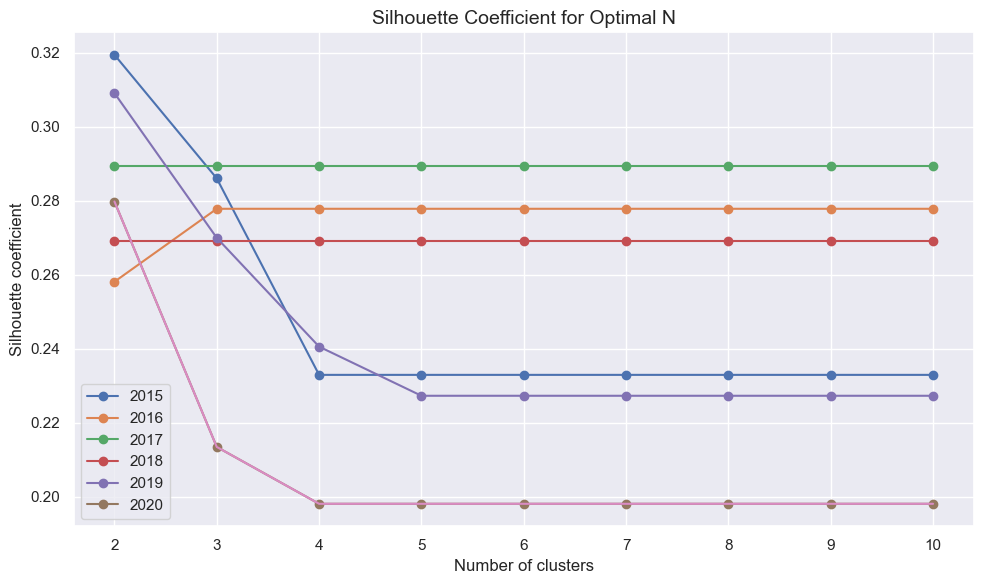

In [17]:
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score

# 准备数据
years = range(2015, 2021) 
plt.figure(figsize=(10, 6)) 
sns.set(style='darkgrid')  # 设置Seaborn风格为白色网格 

# 使用轮廓系数确定最佳簇数
for year in years:
    silhouette_scores = []
    for k in range(2, 11):
        model = Birch(n_clusters=k)
        model.fit(data_by_year[year])
        silhouette_scores.append(silhouette_score(data_by_year[year], model.labels_))
    plt.plot(range(2, 11), silhouette_scores, marker='o', label=f'{year}', linewidth=1.5)  # 调整线条粗细

plt.plot(range(2, 11), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette coefficient')
plt.title('Silhouette Coefficient for Optimal N', fontsize=14)
plt.legend()
plt.grid(True)  # 显示网格线
plt.tight_layout()
plt.show()

轮廓系数（silhouette coefficient）是评估聚类质量的一种指标。它通过计算每个数据点与其所在簇内其他数据点的平均距离，以及该数据点与其所在簇外距离最近的簇内其他数据点的平均距离，然后将两者之差除以最大值来得到。轮廓系数的值越大，表示数据点越紧密地聚集在一起，聚类效果越好。轮廓系数的值越小，表示数据点越分散，聚类效果越差。

可以看到在n_cluster为2的时候，silhouette coefficient得分平均最高。

##### 实验二 确定最大样本半径阈值

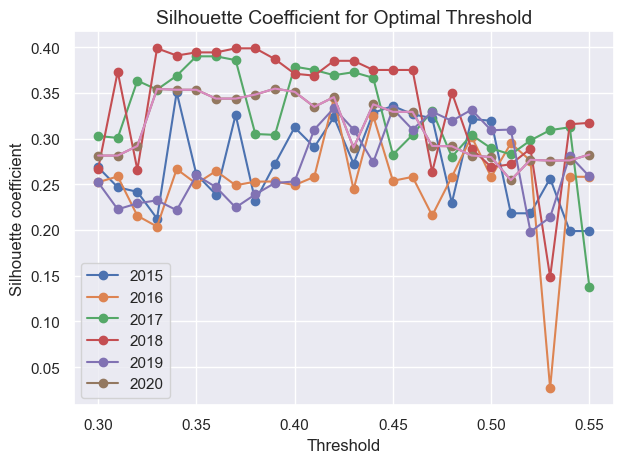

In [86]:
op_n = 2
k_array = np.arange(0.3,0.55,0.01)

for year in years:
    silhouette_scores = []
    for k in k_array:
        model = Birch(threshold=k, n_clusters=op_n)
        model.fit(data_by_year[year])
        silhouette_scores.append(silhouette_score(data_by_year[year], model.labels_))
    plt.plot(k_array, silhouette_scores, marker='o', label=f'{year}', linewidth=1.5)
    
plt.plot(k_array, silhouette_scores)
plt.xlabel('Threshold')
plt.ylabel('Silhouette coefficient')
plt.title('Silhouette Coefficient for Optimal Threshold', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

可以看到，随着threshold变化，聚类效果变化明显。threshold=0.42时，总体效果相对较优。

##### 实验三 确定最大CF数

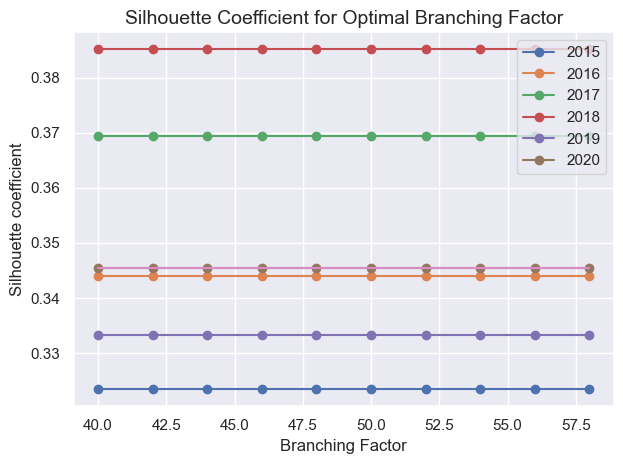

In [87]:
op_n = 2
op_threshold = 0.42
k_array = range(40,60,2)

for year in years:
    silhouette_scores = []
    for k in k_array:
        model = Birch(branching_factor=k, threshold=op_threshold, n_clusters=op_n)
        model.fit(data_by_year[year])
        silhouette_scores.append(silhouette_score(data_by_year[year], model.labels_))
    plt.plot(k_array, silhouette_scores, marker='o', label=f'{year}', linewidth=1.5)

plt.plot(k_array, silhouette_scores)
plt.xlabel('Branching Factor')
plt.ylabel('Silhouette coefficient')
plt.title('Silhouette Coefficient for Optimal Branching Factor', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

曲线基本平直，CF数变化对模型效果没有很大影响。取默认值50。

##### 效果展示

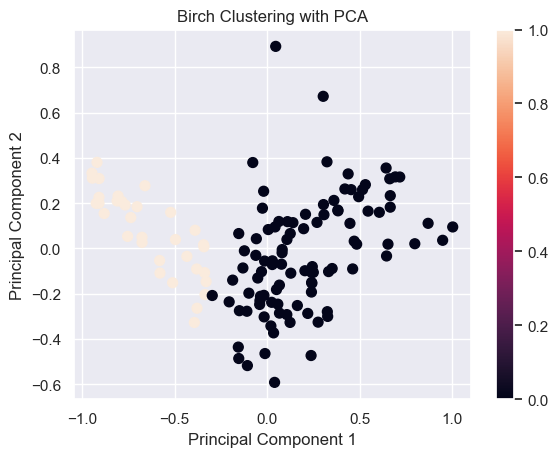

In [89]:
from sklearn.cluster import Birch
from sklearn.decomposition import PCA

data = data_by_year[2015]

from sklearn.cluster import Birch

birch = Birch(
    threshold=0.45, 
    branching_factor=50,
    n_clusters=2, 
    compute_labels=True,
    copy=True)

birch.fit(data)
labels = birch.predict(data)
labels = pd.DataFrame(labels)

# 使用PCA进行特征降维
pca = PCA(n_components=2) # 选择降维后的维度为2
data_reduced = pca.fit_transform(data)

# 绘制散点图
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(data_reduced[:, 0], data_reduced[:, 1], c=labels[0], s=50)
ax.set_title('Birch Clustering with PCA')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.colorbar(scatter)
plt.show()

### 3. MeanShift Clustering

### 4. Spectral Clustering

### 5. DBScan Clustering

DBSCAN（Density-Based Spatial Clustering of Applications with Noise）是一种基于密度的聚类算法，适用于识别具有不同密度的区域，并将数据集分为不同的簇。

其核心思想是通过定义“密度”来区分聚类，而不是假定聚类是基于数据点的距离。这使得DBSCAN能够有效地处理具有不同形状和大小的簇，同时能够识别和过滤掉噪声数据。

DBSCAN的步骤：

1. 参数设置：
   
    ε（epsilon）：邻域半径，即定义一个以数据点为中心的邻域范围。

    MinPts：邻域内最小数据点数目，用于定义核心点和边界点。

2. 核心点（Core Points）：
   
    核心点是在其ε邻域内至少包含MinPts个数据点的数据点。

    若一个点的邻域内的点数大于等于MinPts，则该点为核心点。

3. 边界点（Border Points）：
   
    边界点是在其ε邻域内包含少于MinPts个数据点，但位于核心点的ε邻域内的数据点。

4. 噪声点（Noise Points）：
   
    噪声点是既不是核心点也不是边界点的数据点。
5. 簇的形成：
   
    DBSCAN通过探索核心点的邻域来构建簇。从一个核心点出发，找到其ε邻域内的所有可达点，并将它们添加到同一个簇中。

    簇的形成在核心点及其直接密度可达的点构成的邻域内进行，即可直接或间接连接的点形成一个簇。

6. 密度直达和密度可达：
   
    两个点被称为密度直达，若其中一个点在另一个点的ε邻域内，并且另一个点为核心点。

    两个点被称为密度可达，若存在一系列核心点，每个点都是下一个点的密度直达。

7. 簇的形成结束：
   
    当所有的核心点及其密度可达的点都被探索后，形成一个簇。没有密度直达或密度可达的点将被视为噪声点。
    
通过以上步骤，DBSCAN能够根据数据点之间的密度和连接性，将数据集中的点分为不同的簇、噪声点和离群点，不需要提前指定簇的数量，适用于各种形状和密度分布的数据。

#### 5.1 调用sklearn实现DBSCAN聚类
参数解释：

1. eps（float，默认值为0.5）：被认为是彼此邻域内的两个样本之间的最大距离。这不是簇内点之间距离的最大界限。这是选择适合数据集和距离函数的最重要的DBSCAN参数。

2. min_samples（int，默认值为5）：在一个邻域内被认为是核心点所需的样本数（或总权重）。这包括点本身。如果将min_samples设置为较高的值，DBSCAN将找到更密集的聚类，而如果设置为较低的值，则找到的聚类将更稀疏。

3. metric（str或可调用，默认为'euclidean'）：计算特征数组中实例之间距离时要使用的度量标准。如果metric是字符串或可调用对象，则必须是sklearn.metrics.pairwise_distances允许的选项之一用于其metric参数。如果metric是“precomputed”，则假定X是距离矩阵，并且必须是方阵。X可以是一个稀疏图，其中只有“非零”元素可以被视为DBSCAN的邻居。

4. metric_params（dict，默认为None）：度量函数的附加关键字参数。

5. algorithm（str，默认为'auto'）：NearestNeighbors模块用于计算点间距离和查找最近邻的算法。有关详细信息，请参阅NearestNeighbors模块文档。

6. leaf_size（int，默认为30）：传递给BallTree或cKDTree的叶子大小。这可能会影响构建和查询的速度，以及存储树所需的内存。最佳值取决于问题的性质。

7. p（float，默认为None）：用于计算点之间距离的Minkowski度量的幂。如果为None，则p=2（相当于欧氏距离）。

8. n_jobs（int，默认为None）：要运行的并行作业数。None表示1，除非在joblib.parallel_backend上下文中。-1表示使用所有处理器。


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
# 执行DBSCAN聚类并计算轮廓系数
def doDBSCANClustering(data, eps=0.5, min_samples=5):
    model = DBSCAN(eps=eps, min_samples=min_samples)  # Set the parameters
    start_time = time.time()
    clust_labels = model.fit_predict(data)
    end_time = time.time()
    cost_time = end_time - start_time
    
    try:
        score = metrics.silhouette_score(data, clust_labels)
        noise_ratio = len(clust_labels[clust_labels[:] == -1]) / len(clust_labels)
        n_clusters_ = len(set(clust_labels)) - (1 if -1 in clust_labels else 0)
        return clust_labels, cost_time, score, noise_ratio, n_clusters_
    
    except:
        return  clust_labels, cost_time,None, None, None


##### 实验一 eps, min_samples两个参数的确定实验

In [ ]:
# Specify parameter ranges
eps_range = np.arange(0.2, 10, 0.1)
min_samples_range = np.arange(2, 20, 1)

best_score = 0
best_eps = 0
best_min_samples = 0

results = []

for eps in eps_range:
    for min_samples in min_samples_range:
        clust_labels, cost_time, score, noise_ratio, n_clusters = doDBSCANClustering(data_by_year[2018], eps, min_samples)
        if score is not None:
            results.append([eps, min_samples, score, noise_ratio, n_clusters])
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

results_df = pd.DataFrame(results, columns=['eps', 'min_samples', 'score', 'noise_ratio', 'n_clusters'])

print("Best Silhouette Score:", best_score)
print("Best eps:", best_eps)
print("Best min_samples:", best_min_samples)

# Plotting relationship between score and noise_ratio with changing parameters
sns.relplot(x="eps", y="min_samples", size='score', data=results_df)
sns.relplot(x="eps", y="min_samples", size='noise_ratio', data=results_df)

In [ ]:
#2018年的
cluster_labels, cost_time, score, noise_ratio, n_clusters = doDBSCANClustering(data_by_year[2018], eps=0.2, min_samples=9)
print("Silhouette Score:", best_score)
print("eps:", best_eps)
print("min_samples:", best_min_samples)
dbscan = pd.DataFrame(clust_labels)
print(dbscan)


In [ ]:
# 绘制散点图
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(data_by_year[2019]['gdp_per_capita'], data_by_year[2019]['cpi_score'],
                        c=dbscan[0], s=50)
ax.set_title('DBSCAN Clustering')
ax.set_xlabel('GDP per Capita')
ax.set_ylabel('Cpi_score')
plt.colorbar(scatter)

# 添加消耗时间的文本
text = f'Clustering took {cost_time:.2f} s'  # 格式化文本
ax.text(-0.3, -0.3, text, transform=ax.transAxes, fontsize=12, color='blue')  # 在图表底部添加文本
plt.show()

观察上图结果，可以看到所有数据点都被分配到一个簇时，可能有以下几个原因:
- 数据分布不适合：DBSCAN对数据点的密度和分布敏感。数据点的密度变化较小或数据分布不均匀，导致算法无法有效地将数据点分为具有实际含义的簇。

- 算法局限性：DBSCAN在某些数据集上可能不够灵活，特别是当簇的形状不规则或者数据分布复杂时。在这种情况下，其他聚类算法可能更适合现在的数据。

#### 5.2 自实现DBSCAN聚类

- __init__(self, eps, min_samples): 构造函数初始化myDBSCAN对象的参数，eps和min_samples分别表示DBSCAN算法中的邻域半径和最小样本数。

- fit(self, dataset): 这个函数接受一个数据集dataset作为输入，并对其进行聚类。首先将数据集转换为列表形式，并初始化一些空列表来存储访问过的数据点、聚类结果等。然后按照DBSCAN算法的步骤，对每个样本点进行处理，找到核心点和噪声点，并将它们分配到相应的簇中。

- expand_cluster(self, sample, sample_neighbor, C): 这个函数用于扩展簇。它接收一个样本点sample、样本点的邻居集sample_neighbor以及簇的索引C作为输入，根据DBSCAN算法的要求扩展簇。

- find_neighbors(self, sample): 该函数计算给定样本点sample的邻居点集。它计算该样本点与数据集中其他点之间的距离，将距离小于eps的点加入邻居集。

- create_cluster(self): 这个函数用于为数据集中的每个点创建簇标签。它为数据集中的每个点分配了一个所属的簇索引，并将噪声点标记为-1。

- predict(self, dataset): 这个函数用于对给定的数据集dataset进行预测。它根据已经训练好的聚类模型，将输入的数据点分配到对应的簇或者标记为噪声点。

In [ ]:
import numpy as np
import math

class myDBSCAN :
    # initialize
    def __init__(self, eps, min_samples) :
        self.eps = eps
        self.min_samples = min_samples
        self.visit = []
        self.clusters = []
        self.list_of_cluster = []
        self.noise = []
        self.core = [] # for predict
        self.dataset = []
        
    def fit(self, dataset) : # list
        self.visit = dataset.values.tolist()  # 将 DataFrame 转换为列表
        self.dataset = dataset.values.tolist()
        C = -1 # create cluster
        for data in self.dataset :
            if data in self.visit :
                self.visit.remove(data)
                # find all neighbor for sample data
                data_neighbor = self.find_neighbors(data)
                if len(data_neighbor) < self.min_samples : self.noise.append(data)
                else :
                    C += 1
                    self.expand_cluster(data, data_neighbor, C)
        self.create_cluster()
                    
    def expand_cluster(self, sample, sample_neighbor, C) :
        # first delete clustered element before because it's not core
        for inst in self.clusters :
                if sample in inst : self.clusters[self.clusters.index(inst)].remove(sample)
        self.clusters.insert(C, [sample])
        self.core.append(sample)
        
        for data in sample_neighbor :
            if data in self.visit : # is not visited yet
                self.visit.remove(data)
                data_neighbor = self.find_neighbors(data)
                if len(data_neighbor) >= self.min_samples :
                    self.core.append(data)
                    for elmt in data_neighbor :
                        if elmt not in sample_neighbor : sample_neighbor.append(elmt)
            cluster = False
            for inst in self.clusters :
                if data in inst :
                    cluster = True
                    break
            if cluster == False : 
                self.clusters[C].append(data)
                if data in self.noise : self.noise.remove(data)
    
    def find_neighbors(self, sample) :
        neighbor = []
        for data in self.dataset :
            distance = math.sqrt(sum([(a - b) ** 2 for a, b in zip(sample, data)])) # calculate euclidian distance
            if distance <= self.eps : neighbor.append(data)        
        return neighbor
    
    def create_cluster(self) :
        for data in self.dataset :
            for i in range(len(self.clusters)) :
                if data in self.clusters[i] : 
                    self.list_of_cluster.append(i)
            if data in self.noise : 
                self.list_of_cluster.append(-1)
        self.list_of_cluster = np.array(self.list_of_cluster)
        
    def predict(self, dataset) :
        pred = []
        for data in dataset.values.tolist() :
            appended = False
            for core_ in self.core :
                distance = math.sqrt(sum([(a - b) ** 2 for a, b in zip(core_, data)])) # calculate euclidian distance
                #print("distance between ", data, " and ", core_, " is ", distance)
                if distance <= self.eps : 
                    #print("it is in cluster ", self.dataset.index(core_))
                    pred.append(self.list_of_cluster[self.dataset.index(core_)])
                    appended = True
                    break
            if appended == False : 
                pred.append(-1)
        return np.array(pred)

In [ ]:
# 创建 DBSCAN_mn 类的实例
dbscan = myDBSCAN(eps=0.5, min_samples=5)

# 使用自定义的 DBSCAN_mn 类进行聚类
dbscan.fit(data_by_year[2018])

# 创建 DataFrame 来展示聚类结果
cluster_labels = dbscan.list_of_cluster  # 获取聚类标签
dbscan_result = pd.DataFrame(cluster_labels, columns=["Cluster"])

print(cluster_labels)


In [ ]:
labels =  dbscan_result['Cluster']
colors = np.where(labels == -1, 'red', labels)  # 将噪声点的标签替换为红色

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(data_by_year[2018]['gdp_per_capita'], data_by_year[2018]['cpi_score'],
                        c=colors, s=50)
ax.set_title('DBSCAN Clustering')
ax.set_xlabel('GDP per Capita')
ax.set_ylabel('CPI Score')

# 显示颜色条
plt.colorbar(scatter)

plt.show()


### 6. AffinityPropagation Clusterin

AffinityPropagation Clustering（亲和传播聚类）是一种基于数据点之间的相似性传播的聚类算法。与传统的聚类算法不同，AffinityPropagation 不需要预先指定聚类的个数，而是自动根据数据的相似性选择代表性的样本作为聚类中心。

AffinityPropagation 的核心思想是通过计算数据点之间的相似性来传播信息，从而确定每个数据点的聚类归属。相似性可以使用数据点之间的欧氏距离、相似度度量（如相似矩阵）或其他度量方式来计算。

算法的基本步骤如下：
1. 初始化每个数据点的聚类归属度（responsibility）和聚类偏好度（availability）。
2. 根据当前的聚类归属度和聚类偏好度，更新每个数据点的聚类归属度和聚类偏好度。
3. 重复步骤2，直到收敛或达到最大迭代次数。

AffinityPropagation 的优点包括：
- 不需要预先指定聚类的个数，能够自动选择代表性的样本作为聚类中心。
- 能够处理非凸形状的聚类，适用于各种数据分布。
- 能够估计数据点之间的相似性，并提供样本间的相对强度信息。

然而，AffinityPropagation 也有一些限制：
- 对于大规模数据集，计算复杂度较高。
- 对于具有噪声和异常值的数据，可能会产生不理想的聚类结果。
- 对于数据点之间的相似性度量的选择敏感，需要根据具体问题进行调整。

在使用 AffinityPropagation 时，可以通过调整阈值参数、收敛条件和相似性度量等参数来优化聚类效果。

In [82]:
import numpy as np
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation(
    damping = 0.5, # 阻尼系数
    max_iter = 200, # 最大迭代次数
    convergence_iter = 15, # 聚类个数连续 convergence_iter 次迭代都不再改变，就停止迭代
    copy = True, 
    preference = None, # 参考度或称为偏好参数
    affinity = "euclidean", # 'euclidean', 'precomputed'
    verbose = False,
    random_state = None
)

在sklearn中，AffinityPropagation算法的主要参数如下：

1. 阈值参数：
   -  `damping` ：用于平滑聚类结果的阻尼系数，取值范围为[0.5, 1]。默认值为0.5。

2. 收敛条件：
   -  `max_iter` ：最大迭代次数，用于控制算法的收敛性。默认值为200。
   -  `convergence_iter` ：迭代多少次后认为算法已经收敛。默认值为15。

3. 相似性度量：
   -  `affinity` ：用于计算数据点之间相似性的度量方式。可以是预定义的字符串（如"euclidean"表示欧氏距离）或自定义的相似性矩阵。默认值为"euclidean"。

除了上述参数之外，还有一些其他参数可以调整来优化AffinityPropagation的聚类效果，例如：
-  `preference` ：控制聚类结果的偏好度，用于控制聚类中心的数量。默认值为 `None` ，表示自动选择合适的偏好度。
-  `verbose` ：是否输出详细的调试信息。默认值为 `False` 。

##### 实验一 确定damping
damping，阻尼因子，用于减少吸引信息和归属信息以防止更新减少吸引度和归属度信息时数据振荡。

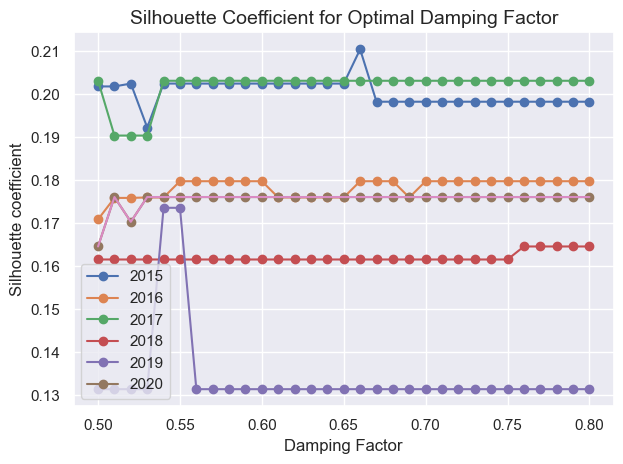

In [83]:
k_array = np.arange(0.5,0.8,0.01) 

for year in years: 
    silhouette_scores = [] 
    for k in k_array: 
        model = AffinityPropagation(damping=k)
        labels = model.fit_predict(data_by_year[year]) 
        silhouette_scores.append(silhouette_score(data_by_year[year], labels)) 
    plt.plot(k_array, silhouette_scores, marker='o', label=f'{year}', linewidth=1.5) 

plt.plot(k_array, silhouette_scores) 
plt.xlabel('Damping Factor') 
plt.ylabel('Silhouette coefficient') 
plt.title('Silhouette Coefficient for Optimal Damping Factor', fontsize=14) 
plt.legend() 
plt.grid(True) 
plt.tight_layout() 
plt.show() 

观察上图结果，可以看出不同年份的聚类效果各不相同。总体来说，damping = 0.55时效果最好。

##### 实验二 确定preference

preference，参考度或称为偏好参数，是相似度矩阵中横轴纵轴索引相同的点，如s(i,i)，若按欧氏距离计算其值应为0，但在AP聚类中其表示数据点i作为聚类中心的程度，因此不能为0。迭代开始前假设所有点成为聚类中心的能力相同，因此参考度一般设为相似度矩阵中所有值得最小值或者中位数，但是参考度越大则说明个数据点成为聚类中心的能力越强，则最终聚类中心的个数则越多；


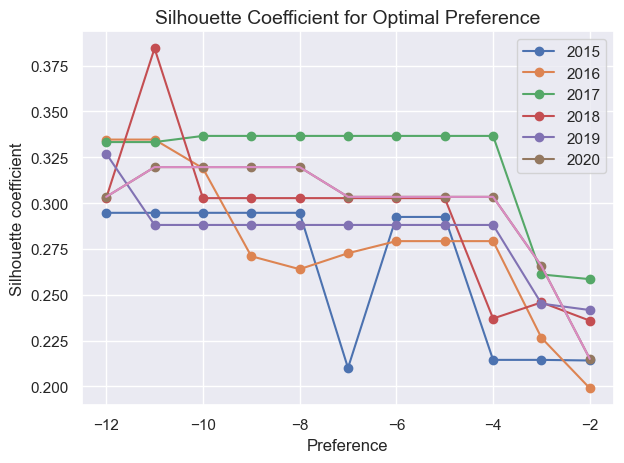

In [84]:
op_damping = 0.55
k_array = np.arange(-12,-1)

for year in years: 
    silhouette_scores = [] 
    for k in k_array: 
        model = AffinityPropagation(damping=op_damping, preference=k)
        labels = model.fit_predict(data_by_year[year]) 
        silhouette_scores.append(silhouette_score(data_by_year[year], labels))
    plt.plot(k_array, silhouette_scores, marker='o', label=f'{year}', linewidth=1.5) 

plt.plot(k_array, silhouette_scores) 
plt.xlabel('Preference') 
plt.ylabel('Silhouette coefficient') 
plt.title('Silhouette Coefficient for Optimal Preference', fontsize=14) 
plt.legend() 
plt.grid(True) 
plt.tight_layout() 
plt.show() 

总体来说，preference = -11时聚类效果最好，且相较于无preference的时候有较大提升。

##### 效果展示

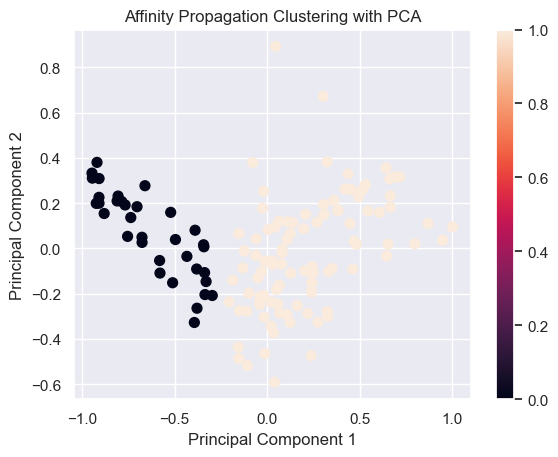

In [85]:
from sklearn.cluster import AffinityPropagation
from sklearn.decomposition import PCA

data = data_by_year[2015]

ap = AffinityPropagation(
    damping = 0.66, # 阻尼系数
    max_iter = 200, # 最大迭代次数
    convergence_iter = 15, # 聚类个数连续 convergence_iter 次迭代都不再改变，就停止迭代
    copy = True, 
    preference = -11, # 参考度或称为偏好参数
    affinity = "euclidean", # 'euclidean', 'precomputed'
    verbose = False,
    random_state = None
)

ap.fit(data)
labels = ap.predict(data)
labels = pd.DataFrame(labels)

# 使用PCA进行特征降维
pca = PCA(n_components=2) # 选择降维后的维度为2
data_reduced = pca.fit_transform(data)

# 绘制散点图
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(data_reduced[:, 0], data_reduced[:, 1], c=labels[0], s=50)
ax.set_title('Affinity Propagation Clustering with PCA')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.colorbar(scatter)
plt.show()

### 7. GaussianMixture Clustering

Gaussian Mixture Clustering（高斯混合聚类）是一种基于概率模型的聚类算法，它假设数据是由多个高斯分布组成的混合模型。每个高斯分布代表一个聚类簇，而混合模型则描述了数据点属于每个聚类的概率。

Gaussian Mixture Clustering 的目标是通过最大化似然函数来估计每个高斯分布的参数，从而确定最佳的聚类结果。常用的参数包括聚类个数、每个聚类的均值和协方差矩阵，以及每个聚类的权重。

算法的基本步骤如下：
1. 初始化每个高斯分布的参数，包括均值、协方差矩阵和权重。
2. 根据当前参数，计算每个数据点属于每个聚类的后验概率。
3. 根据后验概率，更新每个聚类的权重、均值和协方差矩阵。
4. 重复步骤2和3，直到收敛或达到最大迭代次数。

Gaussian Mixture Clustering 的优点包括：
- 能够灵活地处理各种形状和大小的聚类。
- 能够估计数据点属于每个聚类的概率，而不仅仅是硬聚类结果。
- 对于高斯分布的假设使得算法相对简单且易于解释。

然而，Gaussian Mixture Clustering 也有一些限制：
- 对于大规模数据集，计算复杂度较高。
- 对于非高斯分布的数据，可能无法得到最佳结果。

在使用 Gaussian Mixture Clustering 时，可以通过调整聚类个数、初始化策略和收敛条件等参数来优化聚类效果。

In [73]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(
    n_components = 1,
    covariance_type = "full",
    tol = 0.001,
    reg_covar = 0.000001,
    max_iter = 100,
    n_init = 1,
    init_params ="kmeans",
    weights_init = None,
    means_init = None,
    precisions_init = None,
    random_state = None,
    warm_start = False,
    verbose = 0,
    verbose_interval = 10
)

scikit-learn库中的GaussianMixture类的初始化参数如下：

- n_components：混合高斯模型的数量，默认为1。
- covariance_type：协方差类型，包括'full'、'tied'、'diag'和'spherical'四种类型，默认为'full'。
- tol：EM算法的收敛阈值，默认为0.001。
- reg_covar：协方差矩阵的正则化参数，默认为1e-06。
- max_iter：EM算法的最大迭代次数，默认为100。
- n_init：使用不同初始化策略的EM算法的运行次数，默认为1。
- init_params：初始化参数的方式，包括'kmeans', 'k-means++', 'random', 'random_from_data'四种方式，默认为'kmeans'。
- weights_init：混合高斯模型的权重的初始化方式，默认为None。
- means_init：混合高斯模型的均值的初始化方式，默认为None。
- precisions_init：混合高斯模型的精度矩阵的初始化方式，默认为None。
- random_state：随机数生成器的种子，默认为None。
- warm_start：是否使用上一次拟合的结果作为初始化参数，默认为False。
- verbose：是否输出拟合过程中的信息，默认为0。
- verbose_interval：输出拟合过程中的信息的间隔，默认为10。 

其中，n_components、covariance_type、tol、reg_covar、max_iter、n_init和init_params是比较常用的参数。

##### 实验一 确定n_components

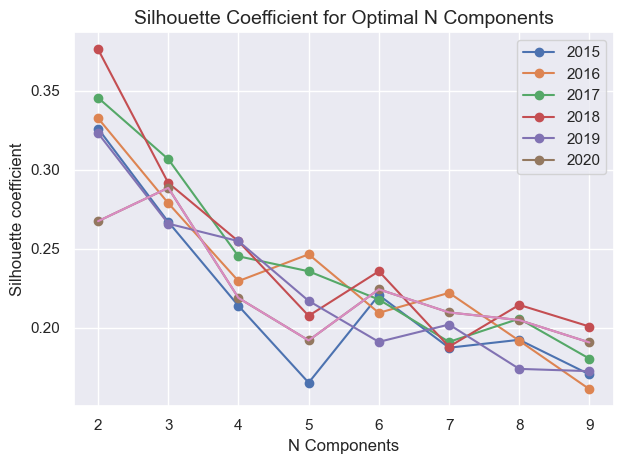

In [20]:
k_array = np.arange(2,10)

for year in years: 
    silhouette_scores = [] 
    for k in k_array: 
        model = GaussianMixture(n_components=k) 
        model.fit(data_by_year[year])
        labels = model.predict(data_by_year[year])
        silhouette_scores.append(silhouette_score(data_by_year[year], labels)) 
    plt.plot(k_array, silhouette_scores, marker='o', label=f'{year}', linewidth=1.5) 

plt.plot(k_array, silhouette_scores) 
plt.xlabel('N Components') 
plt.ylabel('Silhouette coefficient') 
plt.title('Silhouette Coefficient for Optimal N Components', fontsize=14) 
plt.legend() 
plt.grid(True) 
plt.tight_layout() 
plt.show() 

从图中可以看到n_components为2时总体效果最好。

##### 实验二 比较covariance_type：'full'、'tied'、'diag'和'spherical'

* **full**：使用完整的协方差矩阵。 
* **tied**：使用一个协方差矩阵来估计所有特征的协方差。 
* **diag**：使用对角协方差矩阵。 
* **spherical**：使用一个相同的协方差来估计所有特征的协方差。

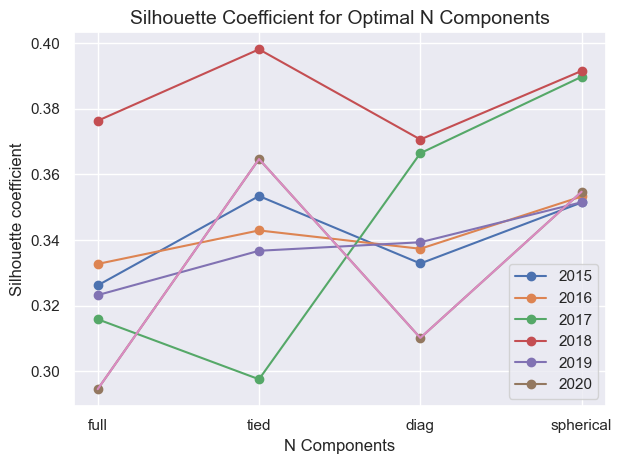

In [21]:
op_n = 2

k_array = ['full','tied','diag','spherical']

for year in years: 
    silhouette_scores = [] 
    for k in k_array: 
        model = GaussianMixture(n_components=op_n, covariance_type=k) 
        model.fit(data_by_year[year])
        labels = model.predict(data_by_year[year])
        silhouette_scores.append(silhouette_score(data_by_year[year], labels)) 
    plt.plot(k_array, silhouette_scores, marker='o', label=f'{year}', linewidth=1.5) 

plt.plot(k_array, silhouette_scores) 
plt.xlabel('Covariance Type') 
plt.ylabel('Silhouette coefficient') 
plt.title('Silhouette Coefficient for Different Covariance Type', fontsize=14) 
plt.legend() 
plt.grid(True) 
plt.tight_layout() 
plt.show() 

对不同年份，最优Covariance Type不一致。
2015年、2018年、2020年在Covariance Type为tied时聚类效果最好；其余3年在Covariance Type为spherical时效果最好。

##### 实验三 比较init_params：'kmeans', 'k-means++', 'random', 'random_from_data'

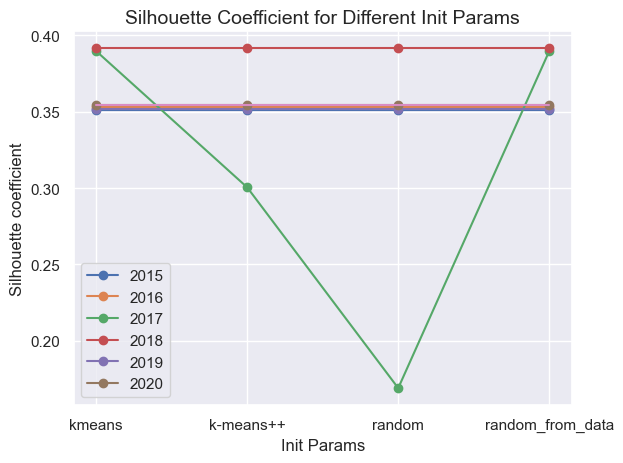

In [72]:
op_n = 2
co = 'spherical'

k_array = ['kmeans', 'k-means++', 'random', 'random_from_data']

for year in years: 
    silhouette_scores = [] 
    for k in k_array: 
        model = GaussianMixture(n_components=op_n, covariance_type=co, init_params=k) 
        model.fit(data_by_year[year])
        labels = model.predict(data_by_year[year])
        silhouette_scores.append(silhouette_score(data_by_year[year], labels)) 
    plt.plot(k_array, silhouette_scores, marker='o', label=f'{year}', linewidth=1.5) 

plt.plot(k_array, silhouette_scores) 
plt.xlabel('Init Params') 
plt.ylabel('Silhouette coefficient') 
plt.title('Silhouette Coefficient for Different Init Params', fontsize=14) 
plt.legend() 
plt.grid(True) 
plt.tight_layout() 
plt.show() 

除了2020年，其它数据对init_params方法变化不敏感。

##### 效果展示

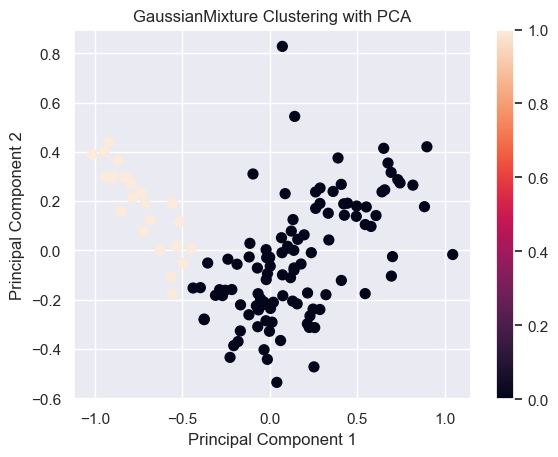

In [80]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

data = data_by_year[2015]

gm = GaussianMixture(
    n_components = 2,
    covariance_type = "spherical",
    tol = 0.001,
    reg_covar = 0.000001,
    max_iter = 100,
    n_init = 2,
    init_params ="kmeans",
)

gm.fit(data)
labels = gm.predict(data)
labels = pd.DataFrame(labels)

# 使用PCA进行特征降维
pca = PCA(n_components=2) # 选择降维后的维度为2
data_reduced = pca.fit_transform(data)

# 绘制散点图
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(data_reduced[:, 0], data_reduced[:, 1], c=labels[0], s=50)
ax.set_title('GaussianMixture Clustering with PCA')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.colorbar(scatter)
plt.show()